In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import defaultdict
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import json
from itertools import chain
#from rich import print
import sys
import os
import utils
import matplotlib.pyplot as plt
import seaborn as sns

# ƒê∆∞·ªùng d·∫´n ƒë·∫øn th∆∞ m·ª•c mini_model
mini_model_path = os.path.abspath(os.path.join(os.getcwd(), ''))

# L·∫•y danh s√°ch t·∫•t c·∫£ th∆∞ m·ª•c con trong mini_model
for folder in os.listdir(mini_model_path):
    folder_path = os.path.join(mini_model_path, folder)
    # Ch·ªâ th√™m n·∫øu l√† th∆∞ m·ª•c v√† kh√¥ng ph·∫£i file
    if os.path.isdir(folder_path):
        if folder_path not in sys.path:
            sys.path.append(folder_path)

import function_get_score_amenities as fga
import function_get_score_rate as fgr
import CF_user_review.CF_user_scores as cfus
import recommenr_review_data as rhr
import review_quality
import recommend_location as rl
import recommend_polices as rp
import recommed_room as rr
import function_get_score_price as fgsp


In [2]:
from pathlib import Path
import config as config 
DEFAULT_BASE_DIR = Path("D:/graduate_dissertation/final")

In [3]:
with open(config.get_path("feature_sub_rate.json"), 'r', encoding='utf-8') as f:
    feature_sub_rate = json.load(f)

with open(config.get_path("weights_criteria_utilities.json"), 'r', encoding='utf-8') as f:
    weights_criteria_utilities = json.load(f)

with open(config.get_path("feature_popular_facilities.json"), 'r', encoding='utf-8') as f:
    feature_popular_facilities = json.load(f)
    
with open(config.get_path("feature_facilities.json"), 'r', encoding='utf-8') as f:
    feature_facilities = json.load(f)

with open(config.get_path("feature_url.json"), 'r', encoding='utf-8') as f:
    feature_url = json.load(f)

with open(config.get_path("feature_allRoom.json"), 'r', encoding='utf-8') as f:
    feature_allRoom = json.load(f)
    
with open(config.get_path("review_processing.json"), 'r', encoding='utf-8') as f:
    result_groupby_id= json.load(f)

with open(config.get_path("feature_location.json"), 'r', encoding='utf-8') as f:
    feature_location = json.load(f)

with open(config.get_path("feature_policies.json"), 'r', encoding='utf-8') as f:
    feature_policies = json.load(f)

with open(config.get_path('hotel_data_room.json'), 'r', encoding='utf-8') as f:
    feature_detail_room = json.load(f)

with open(config.get_path('feature_star_rating.json'), 'r', encoding='utf-8') as f:
    feature_star_rating = json.load(f)


In [4]:
# import json
# import unicodedata

# # H√†m chu·∫©n h√≥a chu·ªói Unicode v·ªÅ NFC
# def normalize_str(s):
#     if isinstance(s, str):
#         return unicodedata.normalize('NFC', s.strip())
#     return s

# # H√†m chu·∫©n h√≥a dict
# def normalize_dict(d):
#     return {normalize_str(k): normalize_str(v) for k, v in d.items()}

# # H√†m chu·∫©n h√≥a d·ªØ li·ªáu dict ho·∫∑c list[dict]
# def normalize_data(data):
#     if isinstance(data, dict):
#         return normalize_dict(data)
#     elif isinstance(data, list):
#         return [normalize_dict(item) for item in data if isinstance(item, dict)]
#     else:
#         return data  # Tr∆∞·ªùng h·ª£p kh√°c th√¨ gi·ªØ nguy√™n

# # Danh s√°ch c√°c file c·∫ßn x·ª≠ l√Ω
# file_keys = {
#     "feature_sub_rate.json": "feature_sub_rate",
#     "weights_criteria_utilities.json": "weights_criteria_utilities",
#     "feature_popular_facilities.json": "feature_popular_facilities",
#     "feature_facilities.json": "feature_facilities",
#     "feature_url.json": "feature_url",
#     "feature_allRoom.json": "feature_allRoom",
#     "review_processing.json": "result_groupby_id",
#     "feature_location.json": "feature_location",
#     "feature_policies.json": "feature_policies",
#     "hotel_data_room.json": "feature_detail_room",
#     "feature_star_rating.json": "feature_star_rating"
# }

# # X·ª≠ l√Ω t·ª´ng file
# for filename in file_keys:
#     path = config.get_path(filename)
    
#     with open(path, 'r', encoding='utf-8') as f:
#         data = json.load(f)
    
#     normalized_data = normalize_data(data)

#     with open(path, 'w', encoding='utf-8') as f:
#         json.dump(normalized_data, f, ensure_ascii=False, indent=4)


#### Load model

In [5]:
recommend_faclities_hotel = fga.HotelSimilarityRecommender(    
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\hotel"),
    type='hotel',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_hotel.load_model()
recommend_faclities_room = fga.HotelSimilarityRecommender(
    model_name='paraphrase-multilingual-MiniLM-L12-v2',
    use_gpu=True,
    model_dir=DEFAULT_BASE_DIR.joinpath("mini_model\\function_get_score_amenities\\model_similarity_amenities\\room"),
    type='room',
    batch_size=256,
    faiss_metric='IP'
)
recommend_faclities_room.load_model()


Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\model.safetensors not found, initializing new model
Initialized new model paraphrase-multilingual-MiniLM-L12-v2 on CPU
Loaded hotel data from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_data.pkl
Loaded vectors from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\hotel_vectors.npy
Loaded Faiss index from D:\graduate_dissertation\final\mini_model\function_get_score_amenities\model_similarity_amenities\hotel\faiss_index.bin
Initializing Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
Using CPU for Sentence-BERT model: paraphrase-multilingual-MiniLM-L12-v2
SafeTensors file D:\graduate_dissertation\

In [6]:
CF = cfus()
state_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_state_for_user.pkl'))
country_model = CF.load_model(DEFAULT_BASE_DIR.joinpath('mini_model\\CF_user_review\\CF_country_for_user.pkl'))

In [7]:
hotel_review_stats = review_quality.HotelReviewStats()
hotel_review_stats.load_stats()

Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json


defaultdict(<function review_quality.HotelReviewStats.load_stats.<locals>.<lambda>()>,
            {'10000593': {'count_review': 446,
              'count_review_with_image': 87,
              'count_long_review': 237,
              'total_score': 4127.0,
              'num_score': 446,
              'avg_score': 9.253363228699552},
             '10000695': {'count_review': 18,
              'count_review_with_image': 0,
              'count_long_review': 3,
              'total_score': 151.0,
              'num_score': 18,
              'avg_score': 8.38888888888889},
             '10001679': {'count_review': 45,
              'count_review_with_image': 7,
              'count_long_review': 21,
              'total_score': 387.0,
              'num_score': 45,
              'avg_score': 8.6},
             '10003086': {'count_review': 36,
              'count_review_with_image': 1,
              'count_long_review': 8,
              'total_score': 308.0,
              'num_score': 36,


In [8]:
def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
    # T·∫°o dict nhanh ƒë·ªÉ tra theo (id, room_id)
    room_lookup = {
        (room['id'], room['room_id']): room['room_score']
        for room in rooms
    }

    results = []
    for hotel in hotels:
        key = (hotel['id'], hotel['room_id'])
        if key in room_lookup:
            room_score = room_lookup[key]
            score_price = hotel.get('room_score_price', 0)
            score_room_infor =  weight[0] * room_score + weight[1] * score_price
            #score_room_infor = 0.6 * room_score + 0.4 * score_price 

            results.append({
                'id': hotel['id'],
                'room_id': hotel['room_id'],
                'score_room': score_room_infor
            })

    return results


In [9]:
def combine_room_and_hotel_scores(rooms, hotel_score_list, weight=0.6):
    # T·∫°o dict ƒë·ªÉ tra nhanh ƒëi·ªÉm hotel theo id
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])  # chuy·ªÉn sang str ƒë·ªÉ kh·ªõp key
        room_score = room['score_room_infor']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            # G·ªôp l·∫°i k·∫øt qu·∫£
            results.append({
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room_infor': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            })

    return results


In [10]:
def combine_room_and_hotel_scores_with_details(
    rooms,
    hotel_score_list,
    extra_score_dicts,
    extra_score_keys,
    weight=0.6
):
    hotel_score_dict = {str(hotel_id): score for hotel_id, score in hotel_score_list}

    results = []
    for room in rooms:
        hotel_id = str(room['id'])
        room_score = room['score_room']

        if hotel_id in hotel_score_dict:
            hotel_score = hotel_score_dict[hotel_id]
            final_score = weight * room_score + (1 - weight) * hotel_score

            result = {
                'id': room['id'],
                'room_id': room['room_id'],
                'score_room': room_score,
                'hotel_score': hotel_score,
                'final_score': final_score
            }

            # Th√™m c√°c ƒëi·ªÉm ƒë√°nh gi√° chi ti·∫øt n·∫øu c√≥
            for score_dict, score_key in zip(extra_score_dicts, extra_score_keys):
                result[score_key] = score_dict.get(room['id'], None)

            results.append(result)

    return results


In [11]:
query = {
    # ====== location ======
    'province': 'Ninh B√¨nh',
    'nearby_places': ["C·ªë ƒë√¥ Hoa L∆∞", "V∆∞·ªùn Chim Thung Nham", "Ninh Binh Train Station"],
    'is_near_center': True,
    'public_transport_access': ['ga t√†u'], # ƒë√£ x·ª≠ l√Ω 50%, 
    # ======
    'price_range': (300000, 1000000),  
    'rating': (3, 5),
    'stars_rating': 3,
    'services': ["D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát"], 
    'criteria': ['V·ªã tr√≠ & m√¥i tr∆∞·ªùng'],
    'amenities': ["TV m√†n h√¨nh ph·∫≥ng", "k√©t an to√†n"],
    'room_type': ['ph√≤ng ƒë∆°n', 'ph√≤ng ƒë√¥i'], # t·∫°m ch∆∞a x·ª≠ l√Ω
    'booking_flexibility': ['h·ªßy mi·ªÖn ph√≠', 'thanh to√°n khi nh·∫≠n ph√≤ng'], # t·∫°m ch∆∞a x·ª≠ l√Ω
    'distance_to_city_center': 5,
    
    'capacity': 2, 
    'country': 'Vi√™Ã£t Nam',
    'state': 'C·∫∑p ƒë√¥i',

    # ====== policies ======
    'policies': {
        "Nh·∫≠n ph√≤ng": '14:00-22:00',
        "Tr·∫£ ph√≤ng": '7:00-12:00',
        "Ch·ªâ thanh to√°n b·∫±ng ti·ªÅn m·∫∑t": None,
        "C√°c ph∆∞∆°ng th·ª©c thanh to√°n ƒë∆∞·ª£c ch·∫•p nh·∫≠n": 'Bankcard',
        "Gi·ªõi h·∫°n ƒë·ªô tu·ªïi": None,
        "Gi·ªù gi·ªõi nghi√™m": 'C·ªïng v√†o ch·ªó ngh·ªâ s·∫Ω ƒë√≥ng trong kho·∫£ng 00:00-5:00',
        "H√∫t thu·ªëc": 'Kh√¥ng cho ph√©p h√∫t thu·ªëc.',
        "H·ªßy ƒë·∫∑t ph√≤ng/ Tr·∫£ tr∆∞·ªõc": 'C√°c ch√≠nh s√°ch h·ªßy v√† thanh to√°n tr∆∞·ªõc',
        "Kh√¥ng gi·ªõi h·∫°n ƒë·ªô tu·ªïi": 'Kh√¥ng c√≥ y√™u c·∫ßu v·ªÅ ƒë·ªô tu·ªïi',
        "Nh√≥m": None,
        "Th·∫ª ƒë∆∞·ª£c ch·∫•p nh·∫≠n t·∫°i ch·ªó ngh·ªâ n√†y": None,
        "Th·∫ª ƒë∆∞·ª£c ch·∫•p nh·∫≠n t·∫°i kh√°ch s·∫°n n√†y": 'Bankcard',
        "Th·ªùi gian y√™n l·∫∑ng": None,
        "Ti·ªác t√πng": 'Cho ph√©p t·ªï ch·ª©c',
        "Tr·∫ª em v√† gi∆∞·ªùng": 'Tr·∫ª em d∆∞·ªõi 5 tu·ªïi',
        "V·∫≠t nu√¥i": 'Cho ph√©p mang v·∫≠t nu√¥i',
        "ƒê·∫∑t c·ªçc ƒë·ªÅ ph√≤ng h∆∞ h·∫°i c√≥ th·ªÉ ho√†n l·∫°i": 'Y√™u c·∫ßu VND 1.000.000 ti·ªÅn ƒë·∫∑t c·ªçc ƒë·ªÅ ph√≤ng h∆∞ h·∫°i khi ƒë·∫øn ngh·ªâ.',
        'room_service_included': 'Kh√¥ng c·∫ßn thanh to√°n tr∆∞·ªõc - thanh to√°n t·∫°i ch·ªó ngh·ªâ\nKh√¥ng c·∫ßn th·∫ª t√≠n d·ª•ng'
    },

    # ====== room ======
    'capacity': 2,
    'room_type': 'Family',
    'room_level': 'Standard', 
    'area': 50,
    'bed_type': '1 gi∆∞·ªùng ƒë√¥i l·ªõn',
    'included_breakfast': True,
    'room_amenties':[],
    'room_facilities':[],
    'room_view': ['Ban c√¥ng'],

}


In [ ]:
def get_score_loaction(query):
    """
    T√≠nh ƒëi·ªÉm cho c√°c kh√°ch s·∫°n d·ª±a tr√™n v·ªã tr√≠ v√† c√°c ti√™u ch√≠ kh√°c.
    """
    # ============================================================
    print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm")
    if query.get('nearby_places') or query.get('province'):
        filter_location_hotels = rl.find_hotels_near_location(
            feature_location, query.get('nearby_places', []), query.get('province'), max_distance_km=20
        )
        result_location_hotels_score = rl.get_location_score(
            filter_location_hotels, query.get('nearby_places', []),
            query.get('province'), query.get('is_near_center', False)
        )
    else:
        result_location_hotels_score = feature_location
        for hotel in result_location_hotels_score:
            hotel['location_score'] = 0
    

    score_location = {}
    ids_result = []
    for hotel in result_location_hotels_score:
        ids_result.append(hotel['id'])
        score_location[hotel['id']] = hotel['location_score']

    
    print( f"üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.")
    
    return ids_result, score_location

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.
319


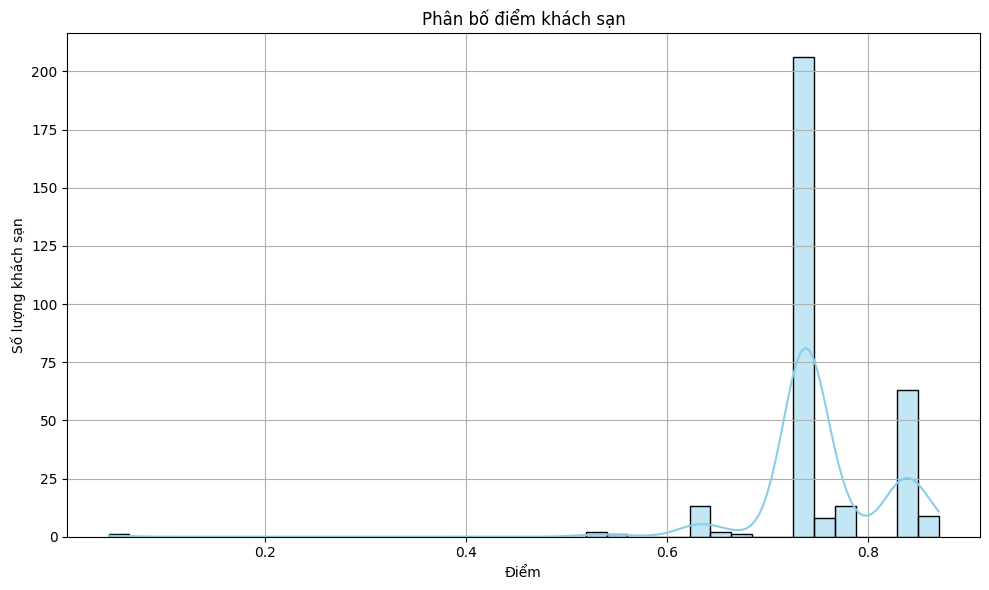

In [13]:
ids_result, score_location = get_score_loaction(query)

print(len(ids_result))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_location.values())

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def get_score_star_rating(ids_result: list, query, feature_star_rating = feature_star_rating):
    """
    T√≠nh ƒëi·ªÉm sao cho c√°c kh√°ch s·∫°n d·ª±a tr√™n ti√™u ch√≠ ƒë√°nh gi√° sao.
    """
    feature_star = []
    for data in feature_star_rating:
        if data['id'] in ids_result:
            feature_star.append(data)

    # 2. Filter star rating
    if query.get('stars_rating') not in [None, '', []]:
        result_stars_hotels_score = fgsp.get_score_rating(query, feature_star)
    else:
        result_stars_hotels_score = []
        for hotel in feature_star_rating:
            result_stars_hotels_score.append({
                'id': hotel['id'],
                'score_rating': 0  
            })
    result_stars_hotels_score = {item['id']: item['score_rating'] for item in result_stars_hotels_score}

    keys_to_remove = [k for k, v in result_stars_hotels_score.items() if v < 0.7]
    for k in keys_to_remove:
        del result_stars_hotels_score[k]

    print(f"üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.")

    return list(result_stars_hotels_score.keys()), result_stars_hotels_score

üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.
307


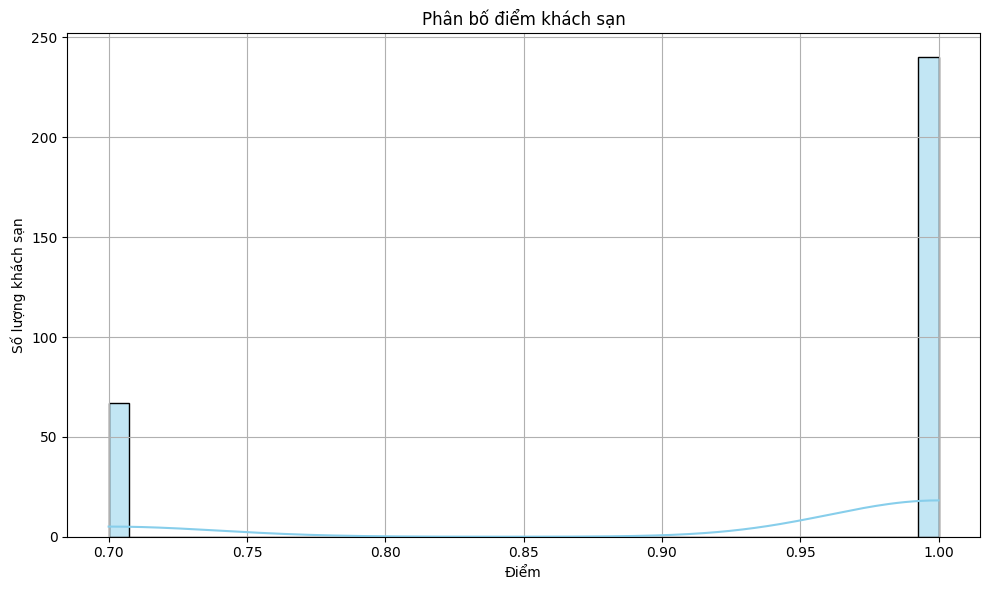

In [15]:
ids_result, score_star_rating = get_score_star_rating(ids_result, query)
print(len(ids_result))

# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_star_rating.values())

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def get_score_price(ids_result, query, feature_detail_room = feature_detail_room):
    # mapping
    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)

    # 3. Filter theo gi√°
    price = query.get('price_range') # x·ª≠ l√Ω input 
    if price not in [None, '', [], (None, None)]:
        result_room_price_score = fgsp.get_price_score(query, detail_room)
        score_price = fgsp.get_max_room_score_per_hotel(result_room_price_score)
    else: 
        score_price = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'hotel_score_price' : 1
            })
        result_room_price_score = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'room_id': price['room_id'],
                'hotel_score_price' : 1
            })

    score_price = {item['id']: item['hotel_score_price'] for item in score_price}
    return score_price, result_room_price_score

307


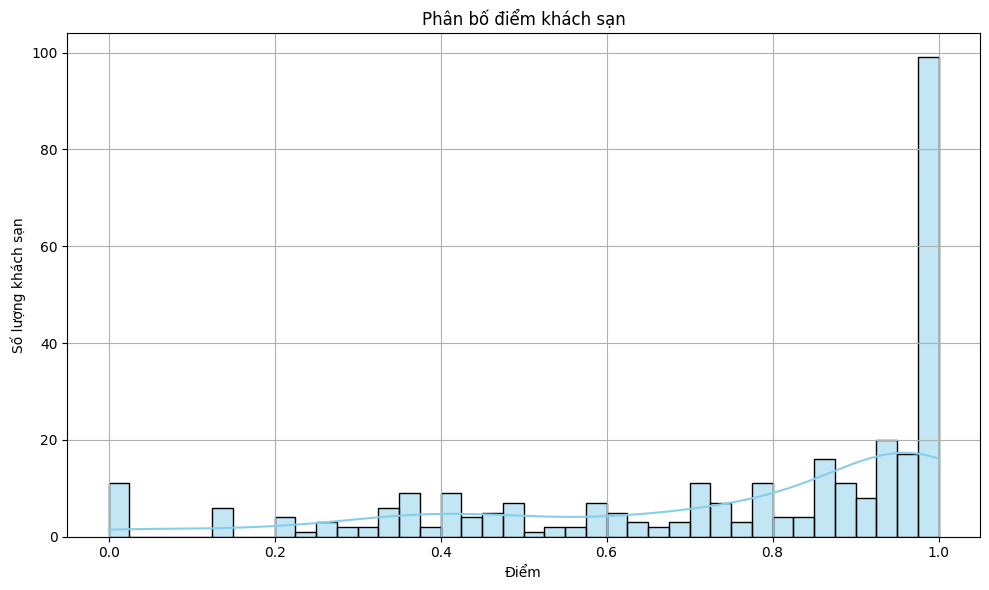

2192


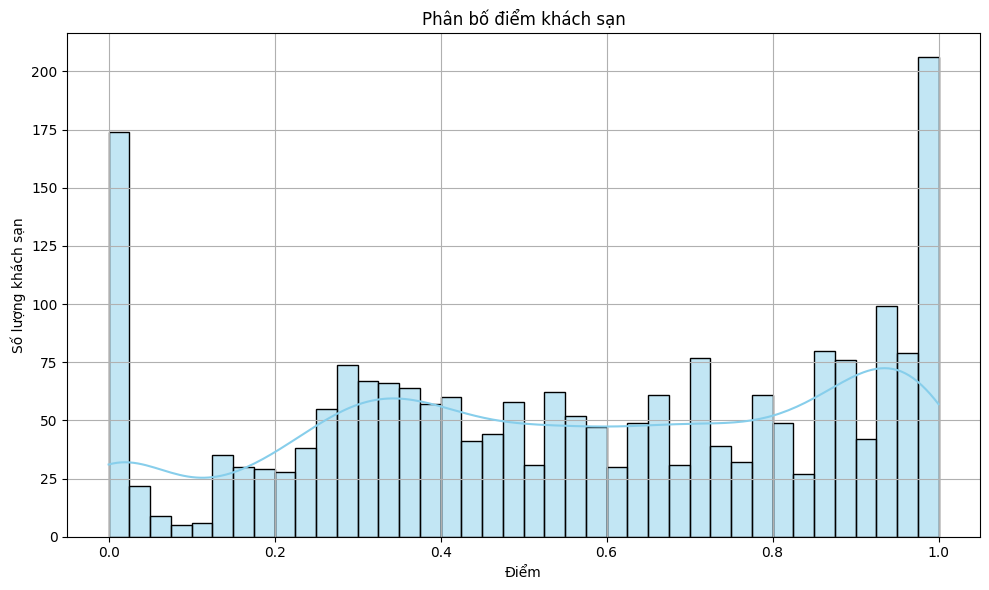

In [17]:
score_price, result_room_price_score = get_score_price(ids_result, query, feature_detail_room)
print(len(score_price))

# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_price.values())

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_price_score))
scores = list([i['room_score_price'] for i in result_room_price_score])
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()


307


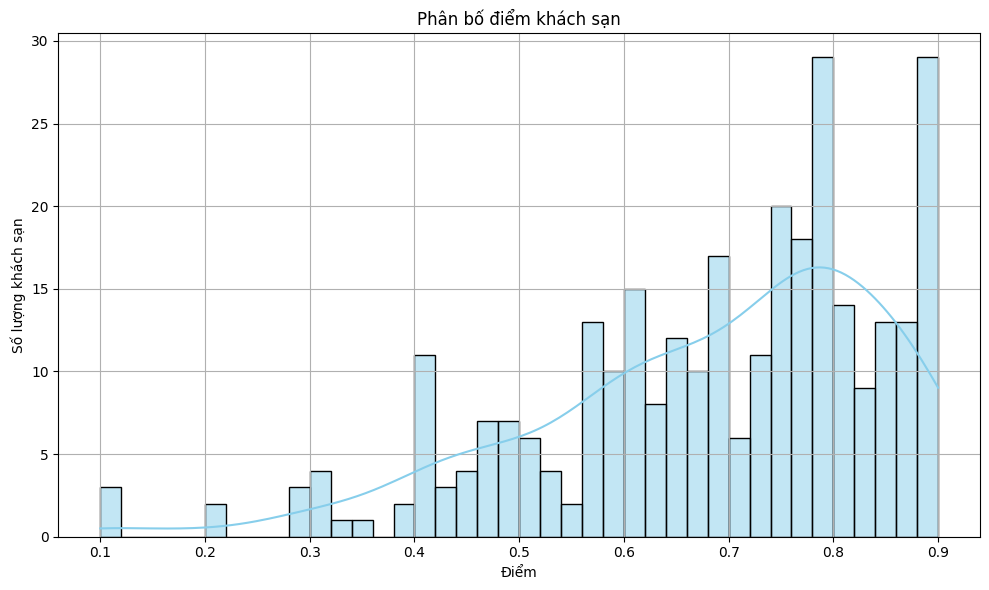

2194


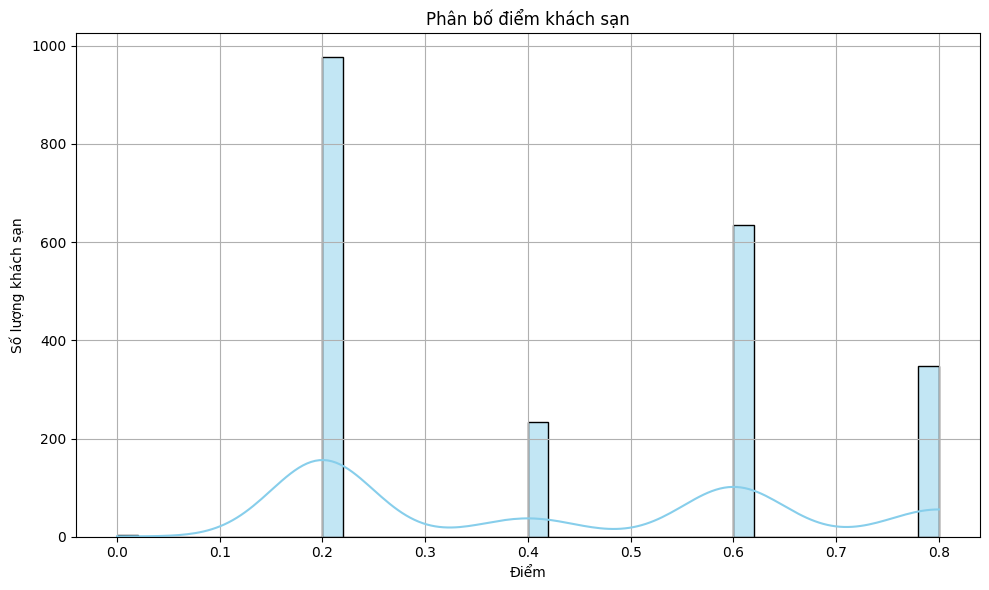

2192


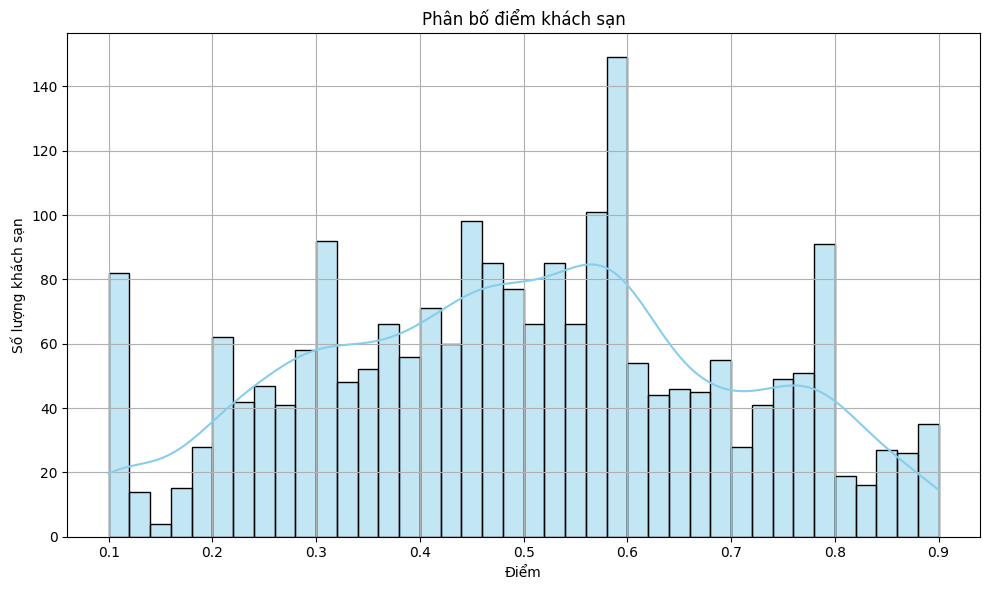

In [18]:
def get_score_room(ids_result, query, feature_detail_room = feature_detail_room, result_room_price_score = result_room_price_score):
    def compute_score_room_infor(hotels, rooms, weight=[0.5, 0.5]):
        # T·∫°o dict nhanh ƒë·ªÉ tra theo (id, room_id)
        room_lookup = {
            (room['id'], room['room_id']): room['room_score']
            for room in rooms
        }

        results = []
        for hotel in hotels:
            key = (hotel['id'], hotel['room_id'])
            if key in room_lookup:
                room_score = room_lookup[key]
                score_price = hotel.get('room_score_price', 0)
                score_room_infor =  weight[0] * room_score + weight[1] * score_price
                #score_room_infor = 0.6 * room_score + 0.4 * score_price 

                results.append({
                    'id': hotel['id'],
                    'room_id': hotel['room_id'],
                    'room_score_price': score_room_infor
                })

        return results


    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)
    score_room_ = rr.get_room_info_score(query, detail_room)
    score_room__ = compute_score_room_infor(result_room_price_score, score_room_) 
    score_room = fgsp.get_max_room_score_per_hotel(score_room__)
    score_room = {item['id']: item['hotel_score_price'] for item in score_room}
    return score_room, score_room_, score_room__

score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query, feature_detail_room, result_room_price_score)
print(len(score_room))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_room.values())

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_info_score))
scores = list([i['room_score'] for i in result_room_info_score])
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

print(len(result_room_info_price_score))
scores = list([i['room_score_price'] for i in result_room_info_price_score])
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
def get_score_policies(ids_result, query, feature_policies=feature_policies):
    print( f" Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.")
    filtered_policies = {} 
    for id in ids_result:
        if id in feature_policies:
            filtered_policies[id] = feature_policies[id]

    score_policies = {} 
    if query.get('policies'):
        for id, data in filtered_policies.items():
            score_policies[id] = rp.find_similar_hotel_policies(query['policies'], data)
            # OUTPUT: {'id':'score', ...}
    
    print( f" ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.")
    return score_policies


 Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.
 ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.
307


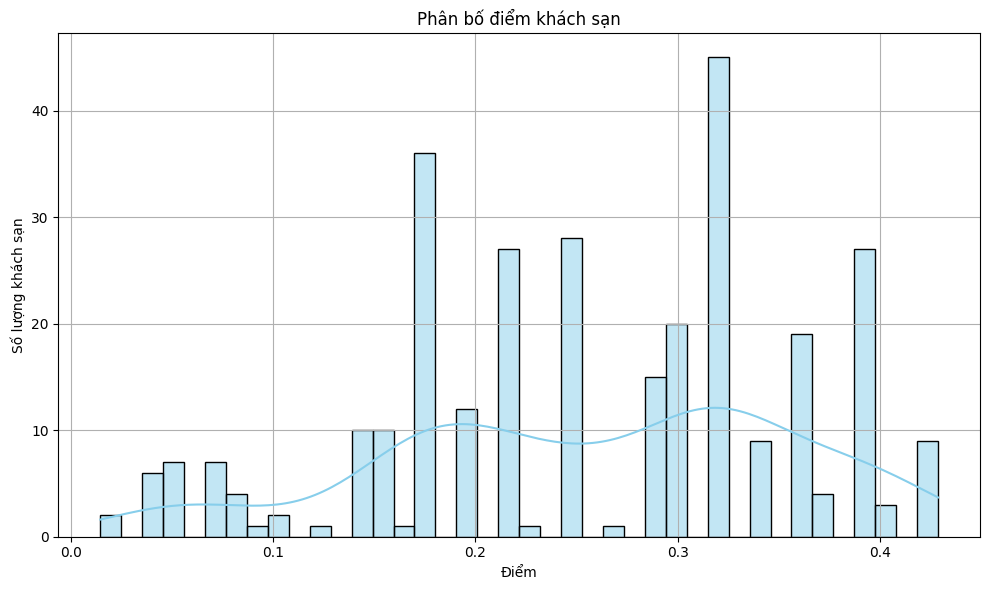

In [20]:
score_policies = get_score_policies(ids_result, query, feature_policies)
print(len(score_policies))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_policies.values())

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
‚úé D·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát[/bold #80CFFF].
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
307


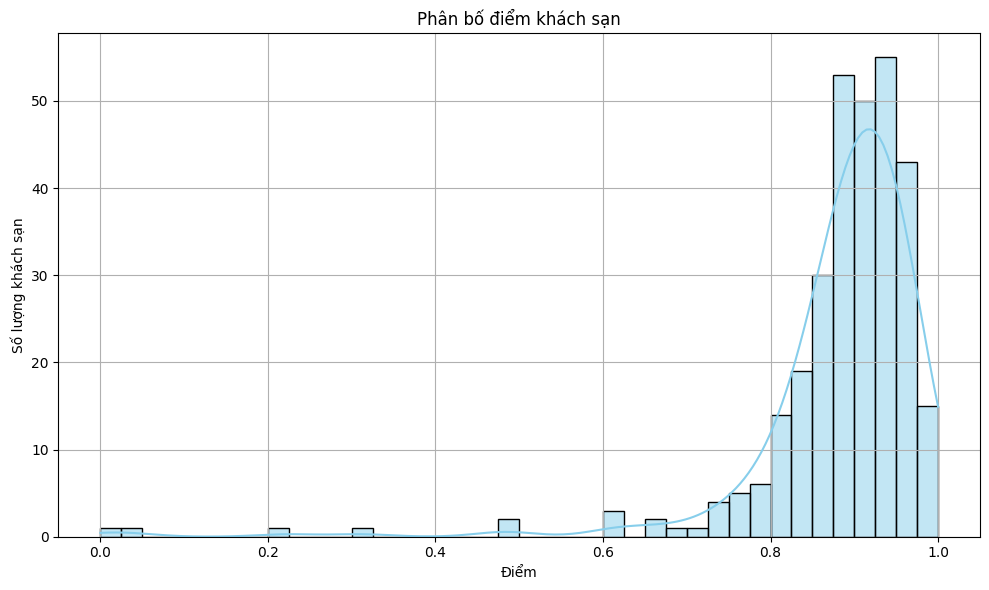

In [21]:
def get_socre_rate_services(ids_result, query, feature_sub_rate=feature_sub_rate):
    """
    T√≠nh ƒëi·ªÉm cho c√°c kh√°ch s·∫°n d·ª±a tr√™n d·ªãch v·ª• v√† ti·ªán nghi.
    """
    print( f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.") 
    if query['services']:
        print(f"‚úé D·ªãch v·ª•: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF].")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        result_services = fgr.get_score_sub_rate(services, utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in result_services}
        # OUTPUT: {'id':'score', ...}

    else:
        print(f"‚úé D·ªãch v·ª•: R·ªóng")
        print(f"‚úé D·ª±a v√†o c√°c ti·ªán √≠ch m√† b·∫°n y√™u c·∫ßu: [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF].")
        designated_utility = set()
        for amenity in query['amenities']:
            cluster = fga.find_clusters([amenity], threshold=0.01)
            designated_utility.update(cluster)
        designated_utility = list(designated_utility)
        print(f"‚úé N√™n s·∫Ω ∆∞u ti√™n c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh cao v·ªõi c√°c ti√™u ch√≠ ƒë√£ ph·ª•c thu·ªôc c√°c ti·ªán √≠ch tr√™n.")
        score_sub_rate_services = fgr.get_score_sub_rate(designated_utility, 
                                                  utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in score_sub_rate_services}
        # OUTPUT: {'id':'score', ...}
    
    print(" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.")
    return score_sub_rate_services


score_sub_rate_services = get_socre_rate_services(ids_result, query, feature_sub_rate)
print(len(score_sub_rate_services))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_sub_rate_services.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()



In [22]:
def get_score_services(ids_result, query, weights=[0.5, 0.5], beta: float = 0.1, use_median: bool = False,):
    # ============================================================
    if query['services']:
        print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF]")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        score_services = fga.get_score_services(user_input = list(services), 
                                    List_ids = ids_result, 
                                    weights=weights, 
                                    beta=beta,
                                    use_median=use_median,)
        score_services = {item['id']: item['final_score'] for item in score_services}
        # OUTPUT: {'id':'score', ...} score n√†y ch∆∞a chu·∫©n h√≥a 
        
        print(f" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.")
    else:
        score_services = {}
    return score_services

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.
307


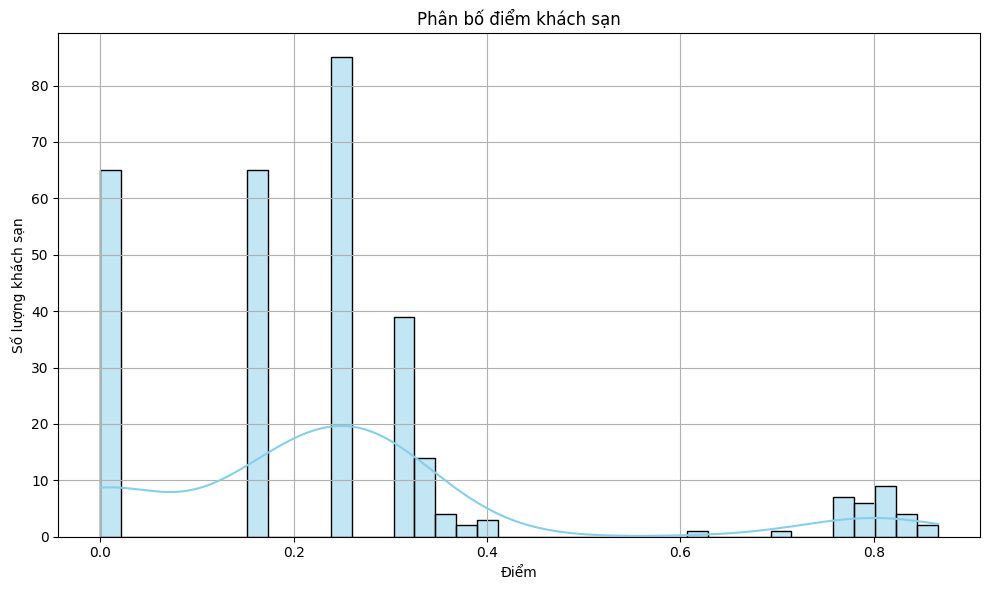

In [23]:
score_services = get_score_services(ids_result, query, weights=[0.5, 0.5], beta=1)
print(len(score_services))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_services.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10):
    # ============================================================
    if query['amenities']:
        print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF]")
        result_facilities_hotel = recommend_faclities_hotel.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )
        result_facilities_room = recommend_faclities_room.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=similarity_threshold, 
            normalization_factor_base=normalization_factor_base
        )

        score_facilities = fga.calculate_hotel_scores(result_facilities_hotel, 
                                   result_facilities_room, 
                                   threshold=0.9, 
                                   weight=[0.5, 0.5])
        
        print(f" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ ti·ªán nghi b·∫°n quan t√¢m.")

        return score_facilities

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]TV m√†n h√¨nh ph·∫≥ng, k√©t an to√†n[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ ti·ªán nghi b·∫°n quan t√¢m.
307


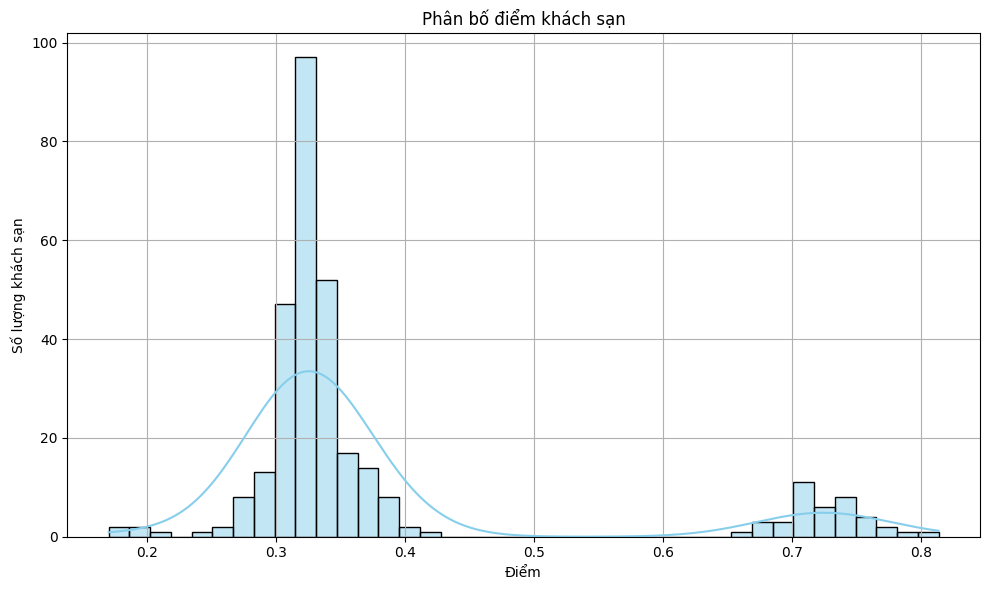

In [25]:
score_facilities = get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10)
print(len(score_facilities))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_facilities.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
def score_review_quality(ids_result, print_warning=False):
    return hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)

222


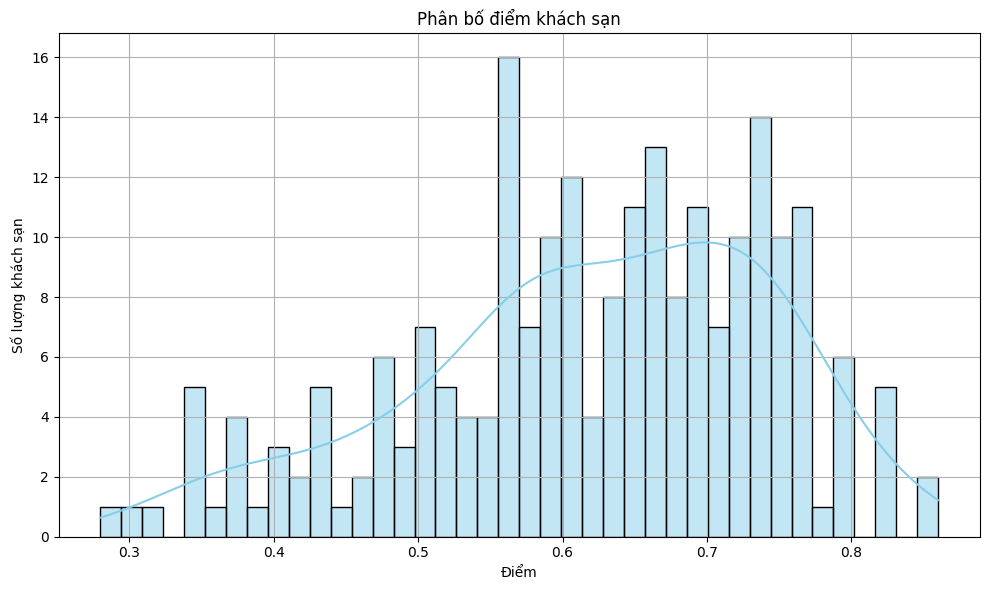

In [27]:
score_quality_review = score_review_quality(ids_result)
print(len(score_quality_review))
# L·∫•y danh s√°ch ƒëi·ªÉm s·ªë
scores = list(score_quality_review.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: Vi√™Ã£t Nam v√† tr·∫°ng th√°i: C·∫∑p ƒë√¥i
üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]V·ªã tr√≠ & m√¥i tr∆∞·ªùng[/bold #80CFFF]
307


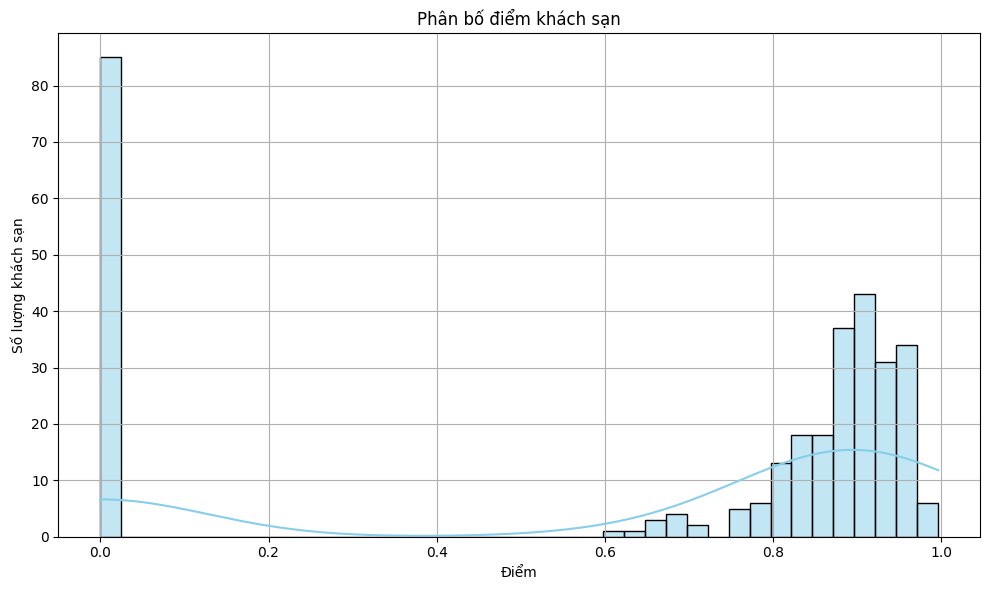

In [28]:
def get_score_review(ids_result, query):
    if not query['country'] and not query['state']: # TH kh√¥ng c√≥ th√¥ng tin v·ªÅ qu·ªëc gia v√† tr·∫°ng th√°i
        if not query['criteria']: # TH kh√¥ng c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                #user_weights = rhr.allocate_weights_with_ratios(), 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
           # OUTPUT : {'id':'score', ...}
        else: # TH c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            print(f"üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                user_weights = weights, 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
         # OUTPUT : {'id':'score', ...}

    else: # TH c√≥ th√¥ng tin v·ªÅ qu·ªëc gia v√† tr·∫°ng th√°i
        print(f"üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: {query['country']} v√† tr·∫°ng th√°i: {query['state']}")
        result = CF.aggregate_prediction(hotel_ids = ids_result, 
                                            country = query['country'], 
                                            status = query['state'], 
                                            state_model=state_model, 
                                            country_model=country_model, 
                                            print_result=False, 
                                            print_warning=False,
                                            )
        if query['criteria']: # TH c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            print(f"üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
        else:
            weights = rhr.allocate_weights_with_ratios()

        score_review = {}
        for key, value in result.items():
            score_review[key] = sum(value[key1] * weights[key1] for key1 in value) / sum(weights.values())

    return score_review


score_use_review = get_score_review(ids_result, query)
print(len(score_use_review))

scores = list(score_use_review.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()

307


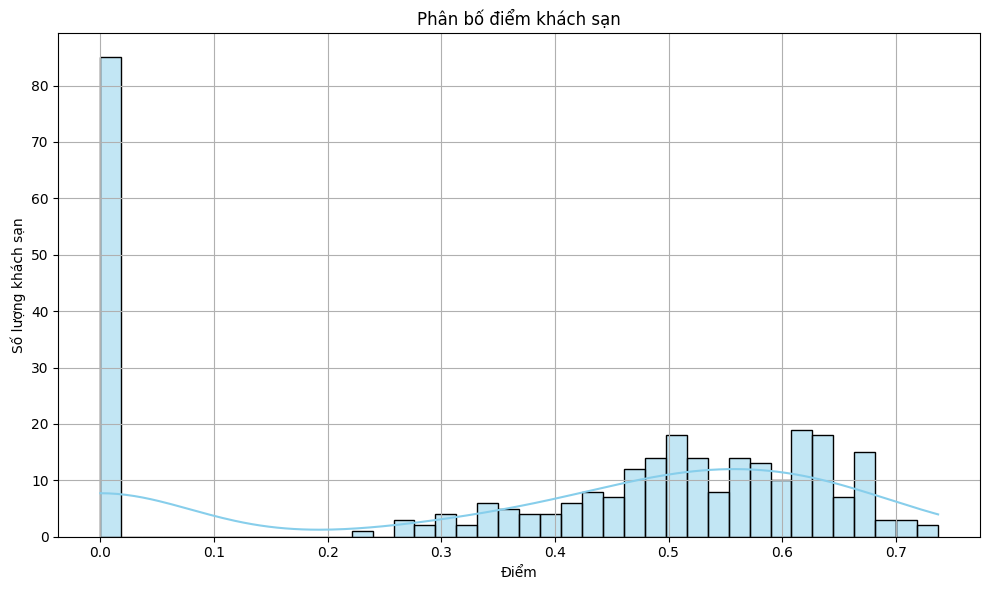

In [29]:
result_final_review_score = rhr.calculate_final_score_from_reviews(
    score_use_review, 
    score_quality_review, 
    w=0.8, 
    q_default=0.5, 
    s_global=0.5,
    threshold=0
)
result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
# OUTPUT : {'id':'score', ...}
print(len(result_final_review_score))

scores = list(result_final_review_score.values())
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë
plt.figure(figsize=(10, 6))
sns.histplot(scores, kde=True, bins=40, color='skyblue')
plt.title('Ph√¢n b·ªë ƒëi·ªÉm kh√°ch s·∫°n')
plt.xlabel('ƒêi·ªÉm')
plt.ylabel('S·ªë l∆∞·ª£ng kh√°ch s·∫°n')
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
# Gi·∫£ s·ª≠ danh s√°ch c√°c dictionary
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    # 'score_review': score_review,
    # 'score_quality_review': score_quality_review,
    # 'result_final_review_score': result_final_review_score,
    # Th√™m c√°c score kh√°c
}

# L·∫•y giao c·ªßa c√°c ID
common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# T·∫°o DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))



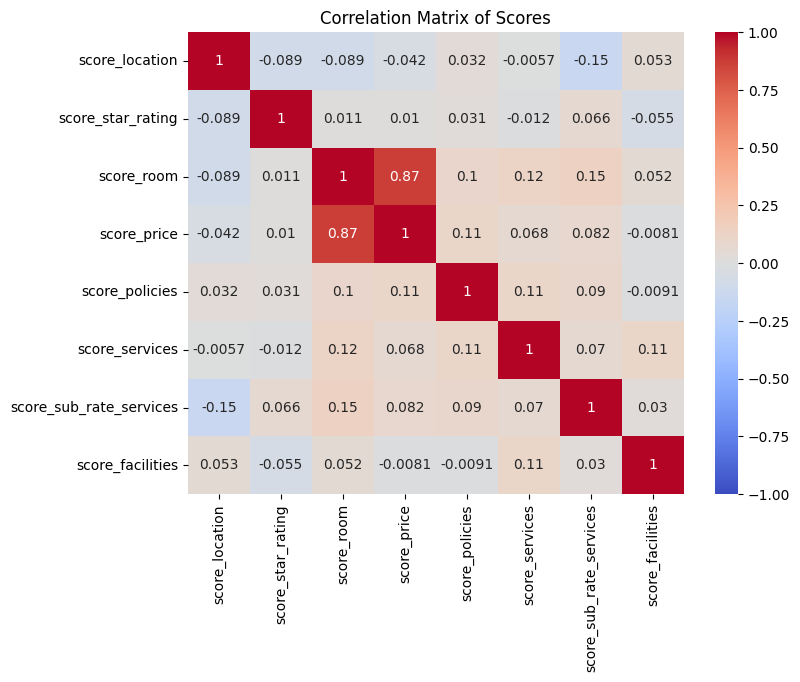

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# T√≠nh ma tr·∫≠n t∆∞∆°ng quan
corr_matrix = df.corr()

# V·∫Ω heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Scores')
plt.show()

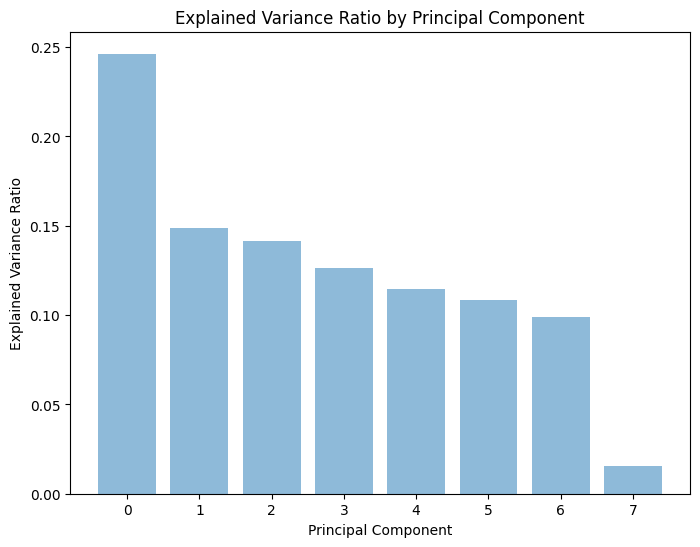

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Chu·∫©n h√≥a d·ªØ li·ªáu (quan tr·ªçng cho PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# √Åp d·ª•ng PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# T·ª∑ l·ªá ph∆∞∆°ng sai ƒë∆∞·ª£c gi·∫£i th√≠ch
explained_variance_ratio = pca.explained_variance_ratio_

# T·∫°o bi·ªÉu ƒë·ªì t·ª∑ l·ªá ph∆∞∆°ng sai
plt.figure(figsize=(8, 6))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.5, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

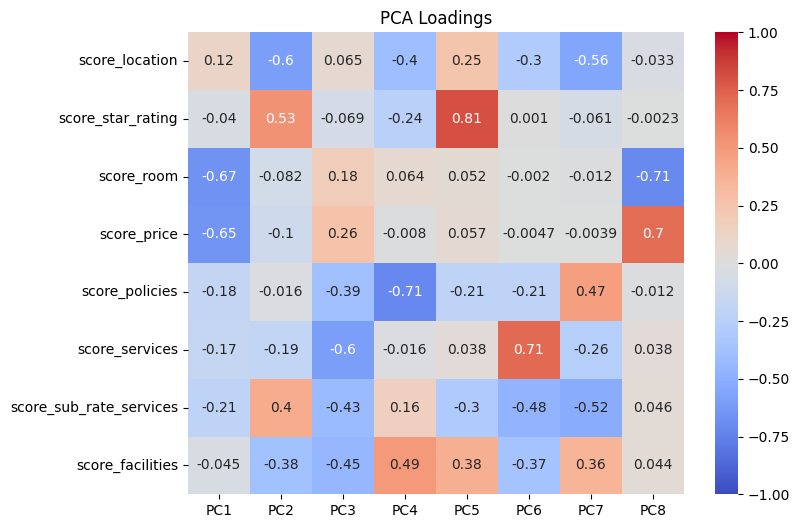

In [33]:
# T·∫£i tr·ªçng c·ªßa c√°c ƒë·∫∑c tr∆∞ng
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))], index=df.columns)

# V·∫Ω heatmap c·ªßa t·∫£i tr·ªçng
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('PCA Loadings')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
from uuid import uuid4

# H√†m t√≠nh ƒëi·ªÉm t·ªïng k·∫øt
def calculate_total_score(df, weights):
    total_score = np.zeros(len(df))
    for i, col in enumerate(df.columns):
        total_score += weights[i] * df[col].values
    return total_score


def get_top_k_per_feature(df, k):
    """
    L·∫•y √≠t nh·∫•t k ph·∫ßn t·ª≠ c√≥ gi√° tr·ªã cao nh·∫•t cho m·ªói c·ªôt trong DataFrame,
    bao g·ªìm t·∫•t c·∫£ c√°c ph·∫ßn t·ª≠ c√≥ gi√° tr·ªã b·∫±ng v·ªõi ph·∫ßn t·ª≠ th·ª© k.

    Parameters:
    - df (pandas.DataFrame): DataFrame ch·ª©a ƒëi·ªÉm s·ªë, v·ªõi c√°c c·ªôt l√† feature v√† ch·ªâ s·ªë l√† ID.
    - k (int): S·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ t·ªëi thi·ªÉu mu·ªën l·∫•y.

    Returns:
    - top_k_dict (dict): T·ª´ ƒëi·ªÉn v·ªõi key l√† t√™n c·ªôt, value l√† t·∫≠p h·ª£p c√°c ch·ªâ s·ªë c·ªßa √≠t nh·∫•t k ph·∫ßn t·ª≠ h√†ng ƒë·∫ßu.
    """
    top_k_dict = {}
    for col in df.columns:
        # L·∫•y gi√° tr·ªã v√† ch·ªâ s·ªë
        values = df[col].values
        indices = np.arange(len(values))  # Ch·ªâ s·ªë g·ªëc
        
        # S·∫Øp x·∫øp theo gi√° tr·ªã gi·∫£m d·∫ßn
        sorted_indices = np.argsort(values)[::-1]
        sorted_values = values[sorted_indices]
        
        # X√°c ƒë·ªãnh ng∆∞·ª°ng gi√° tr·ªã
        if len(sorted_values) >= k:
            threshold_value = sorted_values[k - 1]  # Gi√° tr·ªã t·∫°i v·ªã tr√≠ th·ª© k
        else:
            threshold_value = sorted_values[-1]  # Gi√° tr·ªã cu·ªëi c√πng n·∫øu < k ph·∫ßn t·ª≠
        
        # L·∫•y t·∫•t c·∫£ ch·ªâ s·ªë c√≥ gi√° tr·ªã >= ng∆∞·ª°ng
        top_k_indices = indices[values >= threshold_value]
        
        # L∆∞u v√†o t·ª´ ƒëi·ªÉn d∆∞·ªõi d·∫°ng t·∫≠p h·ª£p
        top_k_dict[col] = set(top_k_indices)
    
    return top_k_dict

# H√†m ki·ªÉm tra t√≠nh h·ª£p l√Ω c·ªßa top k
def evaluate_top_k(df, total_score, k=5, top_k_per_feature = None):
    # L·∫•y top k ID d·ª±a tr√™n ƒëi·ªÉm t·ªïng k·∫øt
    top_k_indices = np.argsort(total_score)[::-1][:k]
    top_k_ids = set(df.index[top_k_indices])
    top_k_df = df.iloc[top_k_indices]
    
    # T√≠nh top k cho m·ªói ƒë·∫∑c tr∆∞ng
    top_k_per_feature = top_k_per_feature
    
    # ƒê·∫øm s·ªë l·∫ßn ID trong top k kh√¥ng n·∫±m trong top k c·ªßa m·ªói ƒë·∫∑c tr∆∞ng
    valid_recommendations = 0
    for id in top_k_ids:
        for col in df.columns:
            if id not in top_k_per_feature[col]:
                valid_recommendations += 1
    
    # T√≠nh ƒë·ªô ƒëa d·∫°ng (ph∆∞∆°ng sai trung b√¨nh c·ªßa c√°c ƒë·∫∑c tr∆∞ng trong top k)
    diversity = top_k_df.std().mean()
    
    return valid_recommendations, diversity

# H√†m ki·ªÉm tra tr·ªçng s·ªë c√≥ th·ªèa m√£n r√†ng bu·ªôc [0.1, 0.3]
def is_valid_weights(weights, min_weight=0.1, max_weight=0.3):
    return all(min_weight <= w <= max_weight for w in weights)

# Th·ª≠ nghi·ªám v·ªõi nhi·ªÅu b·ªô tr·ªçng s·ªë
def test_weights(df, k=5, min_weight=0.1, max_weight=0.3, range_ = 5):
    best_weights = None
    best_score = -1
    results = []
    
    # T·∫°o c√°c t·ªï h·ª£p tr·ªçng s·ªë
    weight_ranges = [np.linspace(min_weight, max_weight, range_)] * len(df.columns)  # [0.1, 0.15, 0.2, 0.25, 0.3]
    total_combinations = 0
    valid_weight_combinations = []
    
    # L·ªçc c√°c t·ªï h·ª£p tr·ªçng s·ªë th·ªèa m√£n t·ªïng b·∫±ng 1 v√† n·∫±m trong [0.1, 0.3]
    for weights in tqdm(product(*weight_ranges), total=range_ ** len(df.columns), desc="Generating weights"):
        weights = np.array(weights)
        weights = weights / weights.sum()  # Chu·∫©n h√≥a
        if is_valid_weights(weights, min_weight, max_weight):
            valid_weight_combinations.append(weights)
            total_combinations += 1

    top_k_per_feature = get_top_k_per_feature(df, int(k*1))
    # S·ª≠ d·ª•ng tqdm ƒë·ªÉ theo d√µi ti·∫øn ƒë·ªô
    for weights in tqdm(valid_weight_combinations, total=total_combinations, desc="Testing weights"):
        total_score = calculate_total_score(df, weights)
        
        valid_recommendations, diversity = evaluate_top_k(df, total_score, k, top_k_per_feature)
        
        # Ch·∫•m ƒëi·ªÉm b·ªô tr·ªçng s·ªë: T·ªëi thi·ªÉu h√≥a vi ph·∫°m, t·ªëi ƒëa h√≥a ƒë·ªô ƒëa d·∫°ng
        score = diversity / (1 + valid_recommendations/k)  # Ngh·ªãch ƒë·∫£o vi ph·∫°m
        results.append({
            'weights': weights,
            'valid_recommendations': valid_recommendations,
            'diversity': diversity,
            'score': score
        })
        
        if score > best_score:
            best_score = score
            best_weights = weights
    
    return best_weights, results




# Th·ª≠ nghi·ªám v·ªõi nhi·ªÅu b·ªô tr·ªçng s·ªë v√† nhi·ªÅu gi√° tr·ªã k
def test_weights_multi_k(df, k_values=[25, 50, 75, 100], min_weight=0.1, max_weight=0.3, range_ = 5):
    results_all = []
    
    # T·∫°o c√°c t·ªï h·ª£p tr·ªçng s·ªë
    weight_ranges = [np.linspace(min_weight, max_weight, range_)] * len(df.columns)  # [0.1, 0.15, 0.2, 0.25, 0.3]
    total_combinations = 0
    valid_weight_combinations = []
    
    # L·ªçc c√°c t·ªï h·ª£p tr·ªçng s·ªë th·ªèa m√£n t·ªïng b·∫±ng 1 v√† n·∫±m trong [0.1, 0.3]
    for weights in tqdm(product(*weight_ranges), total=range_ ** len(df.columns), desc="Generating weights"):
        weights = np.array(weights)
        weights = weights / weights.sum()  # Chu·∫©n h√≥a
        if is_valid_weights(weights, min_weight, max_weight):
            valid_weight_combinations.append(weights)
            total_combinations += 1
    
    # Th·ª≠ nghi·ªám cho t·ª´ng gi√° tr·ªã k
    for k in k_values:
        best_weights = None
        best_score = -1
        results_k = []
        
        top_k_per_feature = get_top_k_per_feature(df, int(k*1))
        print(f"\nTesting for k={k}")
        for weights in tqdm(valid_weight_combinations, total=total_combinations, desc=f"Testing weights (k={k})"):
            total_score = calculate_total_score(df, weights)
            violations, diversity = evaluate_top_k(df, total_score, k, top_k_per_feature)
            
            # Ch·∫•m ƒëi·ªÉm b·ªô tr·ªçng s·ªë: T·ªëi thi·ªÉu h√≥a vi ph·∫°m, t·ªëi ƒëa h√≥a ƒë·ªô ƒëa d·∫°ng
            score = diversity / (1 + violations/k)  # Ngh·ªãch ƒë·∫£o vi ph·∫°m
            results_k.append({
                'weights': weights,
                'violations': violations,
                'diversity': diversity,
                'score': score
            })
            
            if score > best_score:
                best_score = score
                best_weights = weights
        
        
        results_k.sort(key=lambda x: x['score'], reverse=True)

        results_all.append({
            'k': k,
            'best_weights': best_weights,
            'best_score': best_score,
            'results': results_k
        })
    
    return results_all

# Tr·ª±c quan h√≥a k·∫øt qu·∫£
def visualize_results(results_all, df_columns):
    k_values = [r['k'] for r in results_all]
    best_weights = [r['best_weights'] for r in results_all]
    best_scores = [r['best_score'] for r in results_all]
    violations = [min(r['results'], key=lambda x: x['score'])['violations'] for r in results_all]
    diversities = [min(r['results'], key=lambda x: x['score'])['diversity'] for r in results_all]
    
    # Bi·ªÉu ƒë·ªì c·ªôt cho best_weights
    plt.figure(figsize=(10, 6))
    width = 0.1
    x = np.arange(len(k_values))
    for i, col in enumerate(df_columns):
        plt.bar(x + i * width, [w[i] for w in best_weights], width, label=f'w_{col}')
    plt.xlabel('k')
    plt.ylabel('Weight')
    plt.title('Best Weights for Different k Values')
    plt.xticks(x + width * (len(df_columns) - 1) / 2, k_values)
    plt.legend()
    plt.show()
    plt.close()
    
    # Bi·ªÉu ƒë·ªì ƒë∆∞·ªùng cho Violations, Diversity v√† Score
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()

        # Bi·ªÉu ƒë·ªì ƒë∆∞·ªùng cho Violations, Diversity v√† Score
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, diversities, marker='o', label='Diversity')
    plt.plot(k_values, best_scores, marker='o', label='Score')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()




In [35]:
# Gi·∫£ s·ª≠ danh s√°ch c√°c dictionary
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    # 'score_review': score_review,
    # 'score_quality_review': score_quality_review,
    # 'result_final_review_score': result_final_review_score,
    # Th√™m c√°c score kh√°c
}







---

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.
 Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.
 ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
‚úé D·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát[/bold #80CFFF].
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]TV m√†n h√¨nh ph·∫≥ng, k√©t an to√†n[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c k

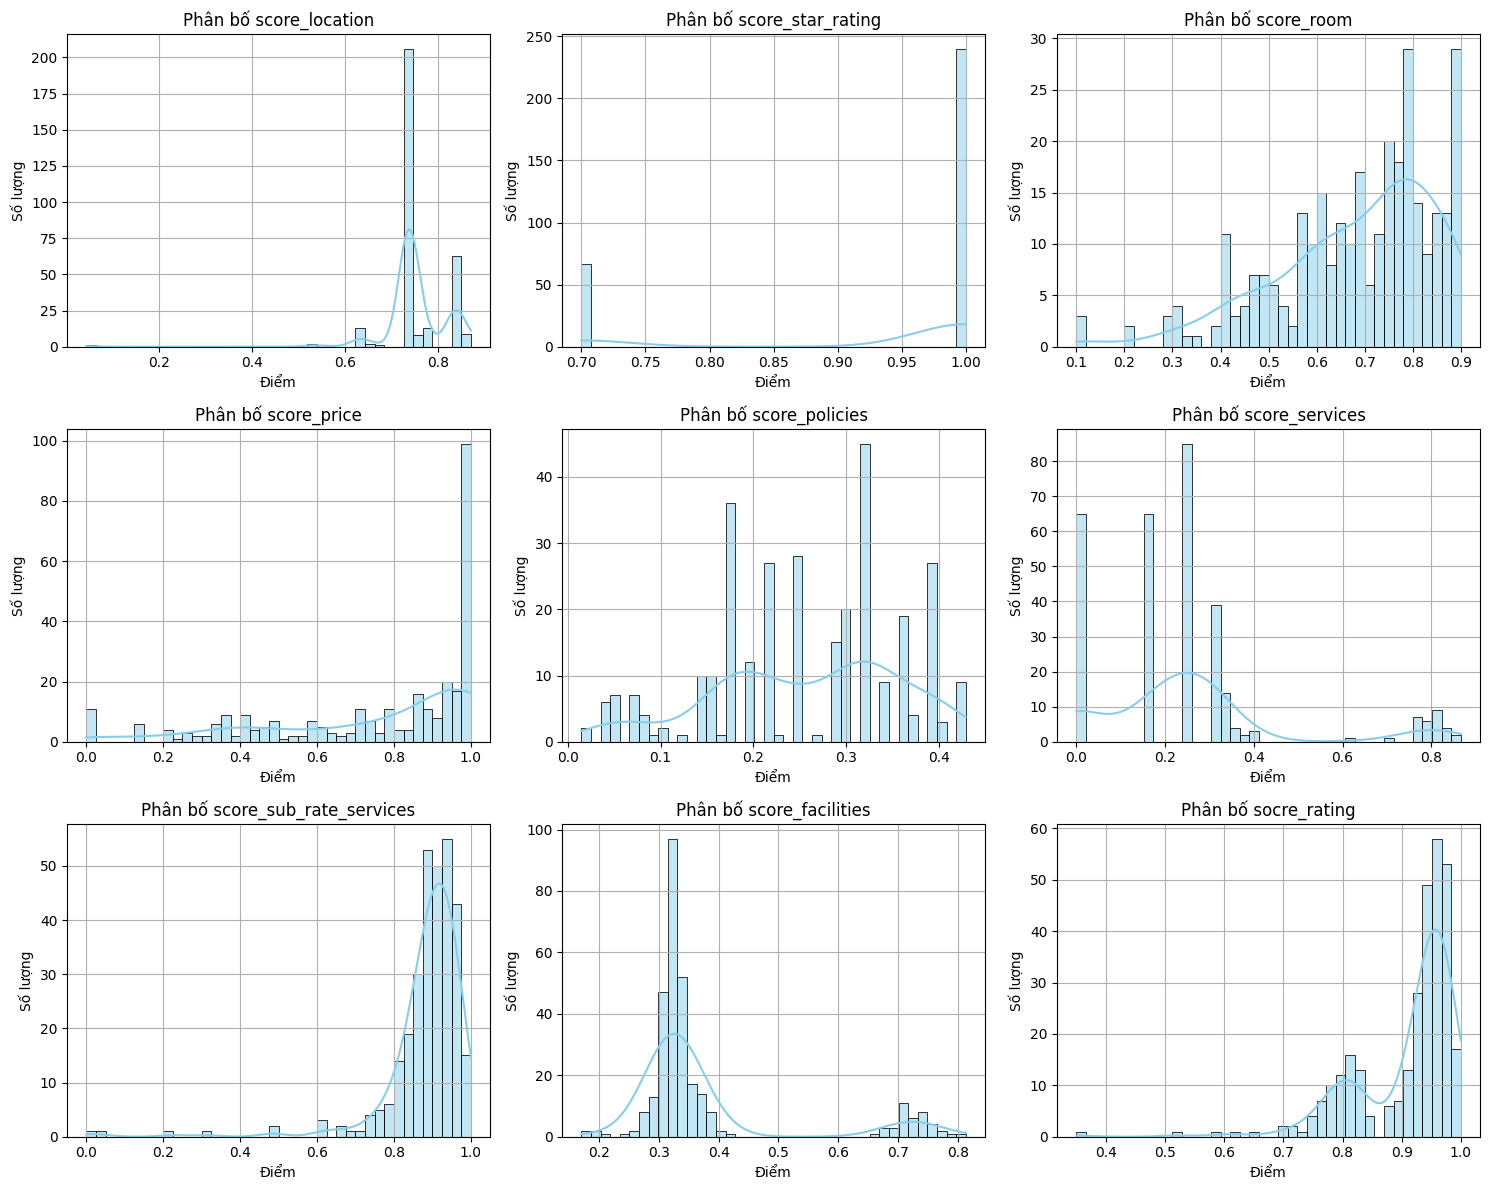

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query)
ids_result, score_star_rating = get_score_star_rating(ids_result, query)
score_price, result_room_price_score = get_score_price(ids_result, query, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query, feature_sub_rate)
score_services = get_score_services(ids_result, query, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))




# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [37]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# T·∫°o DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)




Generating weights: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 117649/117649 [00:00<00:00, 199455.00it/s]



Testing for k=10


Testing weights (k=10): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:18<00:00, 2829.92it/s]



Testing for k=25


Testing weights (k=25): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:20<00:00, 2464.25it/s]



Testing for k=50


Testing weights (k=50): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:21<00:00, 2357.64it/s]


In [38]:
# In k·∫øt qu·∫£
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Tr·ª±c quan h√≥a


Results for k=10:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.1, 'w_score_policies': 0.13333333333333333, 'w_score_services': 0.16666666666666669, 'w_score_facilities': 0.2, 'w_socre_rating': 0.3}
Violations: 52, Diversity: 0.1492, Score: 0.0241

Results for k=25:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.23333333333333334, 'w_score_policies': 0.16666666666666669, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 115, Diversity: 0.1485, Score: 0.0265

Results for k=50:
Best weights: {'w_score_location': 0.10000000000000002, 'w_score_price': 0.10000000000000002, 'w_score_policies': 0.23333333333333336, 'w_score_services': 0.20000000000000004, 'w_score_facilities': 0.2666666666666667, 'w_socre_rating': 0.10000000000000002}
Violations: 200, Diversity: 0.1609, Score: 0.0322


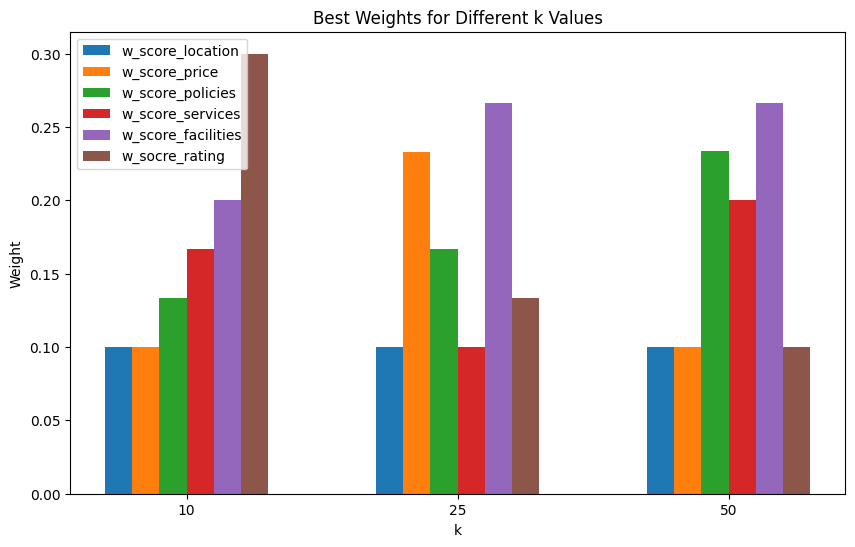

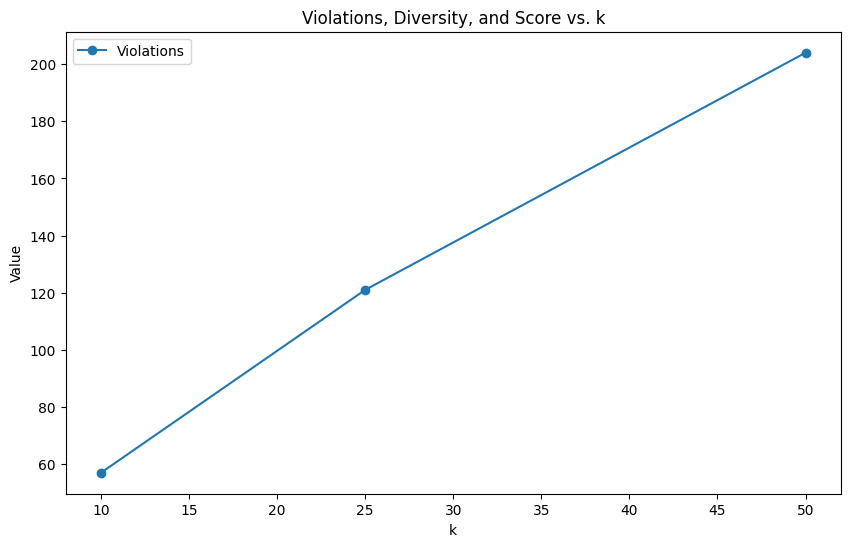

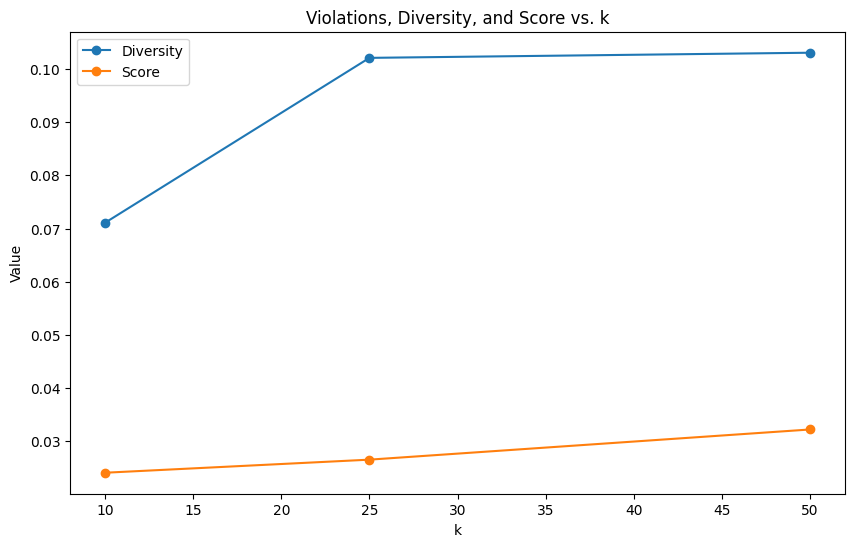

In [39]:
visualize_results(results_all, df.columns)

---

Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: Vi√™Ã£t Nam v√† tr·∫°ng th√°i: C·∫∑p ƒë√¥i
üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]V·ªã tr√≠ & m√¥i tr∆∞·ªùng[/bold #80CFFF]


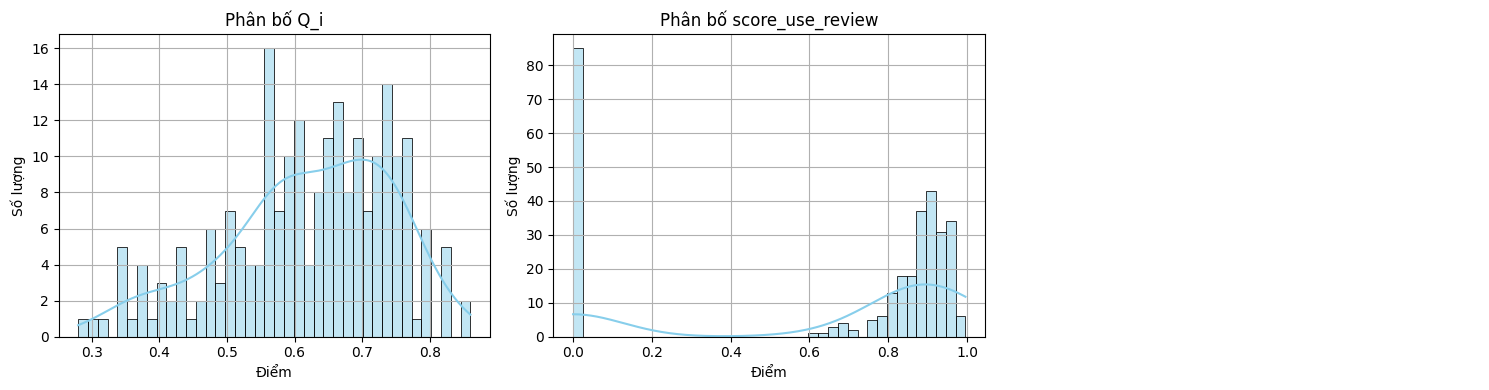

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query)

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [41]:

# B∆∞·ªõc 1: S·∫Øp x·∫øp theo score tƒÉng d·∫ßn
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# B∆∞·ªõc 2: L·∫•y 10 ph·∫ßn t·ª≠ c√°ch ƒë·ªÅu nhau
n = len(sorted_items)
num_samples = 10

# N·∫øu √≠t h∆°n 10 ph·∫ßn t·ª≠, l·∫•y t·∫•t c·∫£
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



In [42]:
for i in result:
    #print(states[i], score_use_review[i])
    print(states[i]['count_review'])


13
18
58
86
120
556
184
351
1002
2784


In [43]:

# B∆∞·ªõc 1: S·∫Øp x·∫øp theo score tƒÉng d·∫ßn
sorted_items = sorted(score_use_review.items(), key=lambda x: x[1])

# B∆∞·ªõc 2: L·∫•y 10 ph·∫ßn t·ª≠ c√°ch ƒë·ªÅu nhau
n = len(sorted_items)
num_samples = 10

# N·∫øu √≠t h∆°n 10 ph·∫ßn t·ª≠, l·∫•y t·∫•t c·∫£
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]

for i in result:
    print(states[i], score_use_review[i])


{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 0, 'count_review_with_image': 0, 'count_long_review': 0, 'total_score': 0.0, 'num_score': 0, 'avg_score': 0.0} 0.0
{'count_review': 76, 'count_review_with_image': 9, 'count_long_review': 21, 'total_score': 669.0, 'num_score': 76, 'avg_score': 8.802631578947368} 0.7819427208420302
{'count_review': 220, 'count_review_with_image': 40, 'count_long_review': 93, 'total_score': 2039.0, 'num_score': 220, 'avg_score': 9.268181818181818} 0.8438733734390749
{'count_review': 116, 'count_review_with_image': 3, 'count_long_review': 33, 'total_score': 1095.0, 'num_score': 116, 'avg_score': 9.439655172413794} 0.8828724376460438
{'count_review': 11, 'count_review_with_image': 0, 'count_long_review': 2, 'total_score': 99.0, 'nu

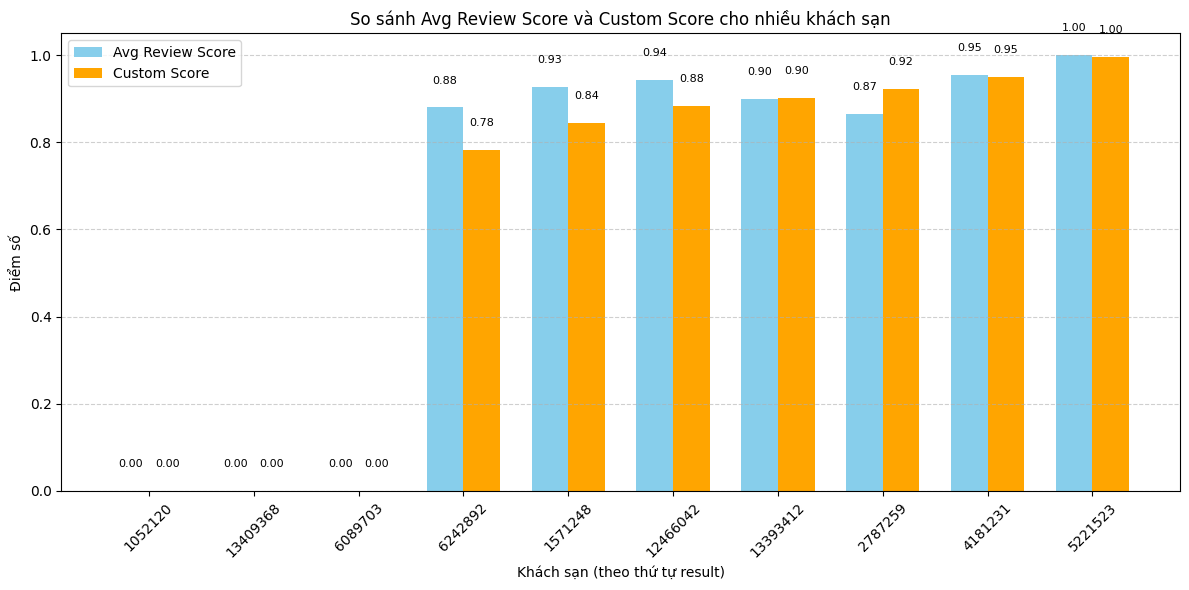

In [44]:


# L·∫•y d·ªØ li·ªáu
avg_scores = [states[i]['avg_score'] / 10 for i in result]
custom_scores = [score_use_review[i] for i in result]

# T·∫°o v·ªã tr√≠ cho c√°c nh√≥m c·ªôt
x = np.arange(10)  # v·ªã tr√≠ c·ªßa c√°c kh√°ch s·∫°n
width = 0.35          # ƒë·ªô r·ªông c·ªßa c·ªôt

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, avg_scores, width, label='Avg Review Score', color='skyblue')
bars2 = plt.bar(x + width/2, custom_scores, width, label='Custom Score', color='orange')

# Th√™m nh√£n tr√™n c·ªôt
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

# G·∫Øn nh√£n, ti√™u ƒë·ªÅ, v.v.
plt.xlabel('Kh√°ch s·∫°n (theo th·ª© t·ª± result)')
plt.ylabel('ƒêi·ªÉm s·ªë')
plt.title('So s√°nh Avg Review Score v√† Custom Score cho nhi·ªÅu kh√°ch s·∫°n')
plt.xticks(x, [f'{i}' for i in result], rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [45]:
S_cadj = score_use_review

In [46]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


# T·∫°o DataFrame
common_ids = list(set(Q_i.keys()).intersection(set(S_cadj.keys())))
data = {
    'S_cadj': [S_cadj[id] for id in common_ids],
    'Q_i': [Q_i[id] for id in common_ids]
}
df = pd.DataFrame(data, index=common_ids)
s_global = 0.5
q_default = 0.5
threshold = 0.0

# Ph√¢n t√≠ch ph√¢n ph·ªëi d·ªØ li·ªáu
def analyze_distribution(df):
    stats = {
        'S_cadj': {
            'mean': df['S_cadj'].mean(),
            'std': df['S_cadj'].std(),
            'variance': df['S_cadj'].var()
        },
        'Q_i': {
            'mean': df['Q_i'].mean(),
            'std': df['Q_i'].std(),
            'variance': df['Q_i'].var()
        }
    }
    # T√≠nh tr·ªçng s·ªë ban ƒë·∫ßu d·ª±a tr√™n ph∆∞∆°ng sai
    var_s_cadj = stats['S_cadj']['variance']
    var_q_i = stats['Q_i']['variance']
    total_var = var_s_cadj + var_q_i
    w_initial = var_q_i / total_var if total_var > 0 else 0.5  # Tr·ªçng s·ªë d·ª±a tr√™n t·ª∑ l·ªá ph∆∞∆°ng sai
    
    print("Distribution Analysis:")
    print(f"S_cadj: Mean={stats['S_cadj']['mean']:.4f}, Std={stats['S_cadj']['std']:.4f}, Variance={stats['S_cadj']['variance']:.4f}")
    print(f"Q_i: Mean={stats['Q_i']['mean']:.4f}, Std={stats['Q_i']['std']:.4f}, Variance={stats['Q_i']['variance']:.4f}")
    print(f"Initial w (based on variance): {w_initial:.4f}")
    
    return stats, w_initial

def calculate_fi(df, w, s_global, q_default, threshold):
    fi_scores = []
    for _, row in df.iterrows():
        s_cadj = row['S_cadj']
        q_i = row['Q_i']
    
        # Tr∆∞·ªùng h·ª£p 1: Kh√¥ng c√≥ ƒë√°nh gi√° (s_adj l√† NaN)
        if pd.isna(s_cadj):
            fi = s_global * q_default
    
        # Tr∆∞·ªùng h·ª£p 2: Kh√¥ng c√≥ quality_score (q_i l√† NaN)
        elif pd.isna(q_i):
            fi = s_cadj * (1 - w) * q_default
    
        # Tr∆∞·ªùng h·ª£p 3: Q_i < threshold
        elif q_i < threshold:
            fi = s_global * q_default
    
        # Tr∆∞·ªùng h·ª£p 4: Q_i = 0
        elif q_i == 0:
            fi = s_cadj * (1 - w) * q_default
    
        # Tr∆∞·ªùng h·ª£p th√¥ng th∆∞·ªùng: Damped Multiplicative Combination
        else:
            fi = s_cadj * (w * q_i + (1 - w) * q_default)
    
        fi_scores.append(fi)

    return np.array(fi_scores)

def calculate_fi(df, w, s_global, q_default, threshold):
    fi_scores = []
    for _, row in df.iterrows():
        s_cadj = row['S_cadj']
        q_i = row['Q_i']

        fi = (w * s_cadj + (1 - w) * q_i)
        
        fi_scores.append(fi)
    
    return np.array(fi_scores)

# H√†m t√≠nh top k
def get_top_k_per_feature(df, k, columns=['S_cadj', 'Q_i']):
    top_k_dict = {}
    for col in columns:
        top_k_indices = np.argsort(df[col].values)[::-1][:min(k, len(df))]
        top_k_dict[col] = set(df.index[top_k_indices])
    return top_k_dict

# H√†m ƒë√°nh gi√° top k
def evaluate_top_k(df, fi_scores, k):
    top_k_indices = np.argsort(fi_scores)[::-1][:min(k, len(df))]
    top_k_ids = set(df.index[top_k_indices])
    top_k_df = df.iloc[top_k_indices]
    
    top_k_per_feature = get_top_k_per_feature(df, k)
    
    violations = 0
    for idx in top_k_ids:
        for col in ['S_cadj', 'Q_i']:
            if idx not in top_k_per_feature[col]:
                violations += 1
    
    diversity = top_k_df[['S_cadj', 'Q_i']].std().mean() if len(top_k_df) > 1 else 0
    
    return violations, diversity

# Th·ª≠ nghi·ªám v·ªõi nhi·ªÅu gi√° tr·ªã w
def test_weights(df, k_values=[25, 50, 75, 100], s_global=0.5, q_default=0.5, threshold=0.3, w_initial=0.5):
    results_all = []
    w_values = np.linspace(max(0.1, w_initial - 0.3), min(0.9, w_initial + 0.3), 20)  # T·∫≠p trung quanh w_initial
    
    for k in k_values:
        best_w = None
        best_score = -1
        results_k = []
        
        print(f"\nTesting for k={k}")
        for w in tqdm(w_values, desc=f"Testing weights (k={k})"):
            fi_scores = calculate_fi(df, w, s_global, q_default, threshold)
            violations, diversity = evaluate_top_k(df, fi_scores, k)
            
            score = diversity / (1 + violations)  # T·ªëi thi·ªÉu h√≥a vi ph·∫°m, t·ªëi ƒëa h√≥a ƒë·ªô ƒëa d·∫°ng
            results_k.append({
                'w': w,
                'violations': violations,
                'diversity': diversity,
                'score': score
            })
            
            if score > best_score:
                best_score = score
                best_w = w
        
        results_k.sort(key=lambda x: x['score'], reverse=True)
        results_all.append({
            'k': k,
            'best_w': best_w,
            'best_score': best_score,
            'results': results_k
        })
    
    return results_all

# Tr·ª±c quan h√≥a k·∫øt qu·∫£
def visualize_results(results_all, w_initial):
    k_values = [r['k'] for r in results_all]
    best_w_values = [r['best_w'] for r in results_all]
    best_scores = [r['best_score'] for r in results_all]
    violations = [min(r['results'], key=lambda x: x['score'])['violations'] for r in results_all]
    diversities = [min(r['results'], key=lambda x: x['score'])['diversity'] for r in results_all]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, best_w_values, marker='o', label='Best w')
    plt.axhline(y=w_initial, color='r', linestyle='--', label='Initial w (variance-based)')
    plt.xlabel('k')
    plt.ylabel('Weight (w)')
    plt.title('Best Weight (w) vs. k')
    plt.legend()
    plt.savefig('best_w_vs_k.png')
    plt.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, violations, marker='o', label='Violations')
    plt.plot(k_values, diversities, marker='o', label='Diversity')
    plt.plot(k_values, best_scores, marker='o', label='Score')
    plt.xlabel('k')
    plt.ylabel('Value')
    plt.title('Violations, Diversity, and Score vs. k')
    plt.legend()
    plt.show()
    plt.close()

# Ph√¢n t√≠ch ph√¢n ph·ªëi v√† ch·∫°y th·ª≠ nghi·ªám
stats, w_initial = analyze_distribution(df)
results_all = test_weights(df, k_values=[10, 25, 50], s_global=s_global, q_default=q_default, threshold=threshold, w_initial=w_initial)



Distribution Analysis:
S_cadj: Mean=0.8840, Std=0.0708, Variance=0.0050
Q_i: Mean=0.6201, Std=0.1236, Variance=0.0153
Initial w (based on variance): 0.7530

Testing for k=10


Testing weights (k=10): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 144.10it/s]



Testing for k=25


Testing weights (k=25): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 153.54it/s]



Testing for k=50


Testing weights (k=50): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 132.56it/s]


* $S_csdj$ c√≥ trung b√¨nh cao h∆°n so v·ªõi $Q_i$. Th·∫•y ƒë∆∞·ª£c ƒëi·ªÉm review ng∆∞·ªùi d√πng th∆∞·ªùng cao h∆°n ƒëi·ªÉm ch·∫•t l∆∞·ª£ng review.
* ƒê·ªô l·ªách chu·∫©n v√† ph∆∞∆°ng sai c·ªßa $Q_i$ l·ªõn h∆°n ƒë√°ng k·ªÉ so v·ªõi $S_cadj$.t·ª©c l√† ƒëi·ªÉm ch·∫•t l∆∞·ª£ng review c√≥ kh·∫£ nƒÉng ph√¢n bi·ªát c√°c kh√°ch s·∫°n t·ªët h∆°n.
* Ta c√≥ ph∆∞∆°ng sai l√† m·ª•c ƒë·ªô ph√¢n t√°n d·ªØ li·ªáu. m·ªôt ƒë·∫∑t tr∆∞ng c√≥ ph∆∞∆°ng sai l·ªõn h∆°n th∆∞·ªùng mang nhi·ªÅu th√¥ng tin h∆°n. v√¨ n√≥ ph·∫£n ·∫£nh s·ª± kh√°ch bi·ªát r√µ r·ªát gi≈©a c√°c ƒë·ªëi t∆∞·ª£ng. 


In [47]:
# In k·∫øt qu·∫£
for result in results_all:
    k = result['k']
    best_w = result['best_w']
    print(f"\nResults for k={k}:")
    print(f"Best w: {best_w:.2f}")
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")




Results for k=10:
Best w: 0.90
Violations: 13, Diversity: 0.0567, Score: 0.0041

Results for k=25:
Best w: 0.90
Violations: 26, Diversity: 0.0554, Score: 0.0021

Results for k=50:
Best w: 0.90
Violations: 34, Diversity: 0.0531, Score: 0.0015


---

In [76]:
query_many_hotels = {
    'province': 'Th√†nh ph·ªë H·ªì Ch√≠ Minh',
    'nearby_places': ['Ch·ª£ B·∫øn Th√†nh', 'Ph·ªë ƒëi b·ªô Nguy·ªÖn Hu·ªá'],
    'is_near_center': True,
    'public_transport_access': ['tr·∫°m xe bu√Ωt', 'ga t√†u'],
    'price_range': (500000, 2000000),
    'stars_rating': 4,
    'services': ['D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát', 'Ti·ªán √≠ch gi·∫£i tr√≠ & spa'],
    'criteria': ['V·ªã tr√≠ & m√¥i tr∆∞·ªùng', 'D·ªãch v·ª• & nh√¢n vi√™n'],
    'amenities': ['TV m√†n h√¨nh ph·∫≥ng', 'm√°y l·∫°nh', 'qu·∫ßy bar mini'],
    
    'booking_flexibility': ['h·ªßy mi·ªÖn ph√≠'],
    'distance_to_city_center': 5,
    'capacity': 2,
    'country': 'Vi√™Ã£t Nam',
    'state': 'C·∫∑p ƒë√¥i',
    'policies': {
        'Nh·∫≠n ph√≤ng': '14:00-23:00',
        'Tr·∫£ ph√≤ng': '7:00-12:00',
        'H·ªßy ƒë·∫∑t ph√≤ng/ Tr·∫£ tr∆∞·ªõc': 'H·ªßy mi·ªÖn ph√≠ trong v√≤ng 24h',
        'V·∫≠t nu√¥i': 'Kh√¥ng cho ph√©p',
    },
    'room_type': 'Double Room',
    'included_breakfast': True,
    'room_level': '',
    'bed_type': '1 gi∆∞·ªùng ƒë√¥i l·ªõn',
    'area': 35,
    'room_view': ['Ban c√¥ng']
}


In [69]:
ids_result, score_location = get_score_loaction(query_many_hotels)

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.


In [72]:
score_location

{'257543': 0.8299,
 '264198': 0.8299,
 '10128837': 0.825,
 '294771': 0.825,
 '2597342': 0.8246,
 '11971962': 0.82,
 '264986': 0.82,
 '1312425': 0.8199,
 '10012516': 0.38,
 '1002711': 0.38,
 '10052199': 0.38,
 '10059536': 0.38,
 '10059845': 0.38,
 '10112773': 0.38,
 '10175818': 0.38,
 '10230604': 0.38,
 '10257028': 0.38,
 '10257358': 0.38,
 '10322238': 0.38,
 '10335019': 0.38,
 '10367890': 0.38,
 '10410565': 0.38,
 '10505705': 0.38,
 '10533390': 0.38,
 '10577278': 0.38,
 '10600192': 0.38,
 '10618677': 0.38,
 '10636046': 0.38,
 '1063721': 0.38,
 '10668578': 0.38,
 '10868832': 0.38,
 '1087399': 0.38,
 '10874751': 0.38,
 '10915959': 0.38,
 '10967940': 0.38,
 '10973516': 0.38,
 '10978493': 0.38,
 '1097973': 0.38,
 '10980611': 0.38,
 '1102388': 0.38,
 '11058407': 0.38,
 '11061532': 0.38,
 '1108901': 0.38,
 '11099373': 0.38,
 '11108037': 0.38,
 '11110404': 0.38,
 '11161251': 0.38,
 '11186552': 0.38,
 '11192005': 0.38,
 '11192379': 0.38,
 '11203515': 0.38,
 '11205740': 0.38,
 '11212692': 0.38,

In [74]:
utils.filter_matching_elements(ids_result, feature_url)

[{'id': '10012516',
  'url': 'https://www.booking.com/hotel/vn/t-zone-house.vi.html?checkin=2025-03-20&checkout=2025-03-21'},
 {'id': '10012717',
  'url': 'https://www.booking.com/hotel/vn/chez-lotus-rose.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '1002711',
  'url': 'https://www.booking.com/hotel/vn/iris.vi.html?checkin=2025-03-25&checkout=2025-03-26'},
 {'id': '10034269',
  'url': 'https://www.booking.com/hotel/vn/luxury-rooms.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10052199',
  'url': 'https://www.booking.com/hotel/vn/chez-lotus-vn.vi.html?checkin=2025-03-20&checkout=2025-03-21'},
 {'id': '10059536',
  'url': 'https://www.booking.com/hotel/vn/ecodotel-apartment-2.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10059845',
  'url': 'https://www.booking.com/hotel/vn/camelia-108-le-lai.vi.html?checkin=2025-05-25&checkout=2025-05-26'},
 {'id': '10105817',
  'url': 'https://www.booking.com/hotel/vn/la-vie-saigon-homestay.vi.html?checkin=2025-05

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.
 Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.
 ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
‚úé D·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát, Ti·ªán √≠ch gi·∫£i tr√≠ & spa[/bold #80CFFF].
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• s·ª± ki·ªán & h·ªó tr·ª£ ƒë·∫∑c bi·ªát, Ti·ªán √≠ch gi·∫£i tr√≠ & spa[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]TV m√†n h√¨nh 

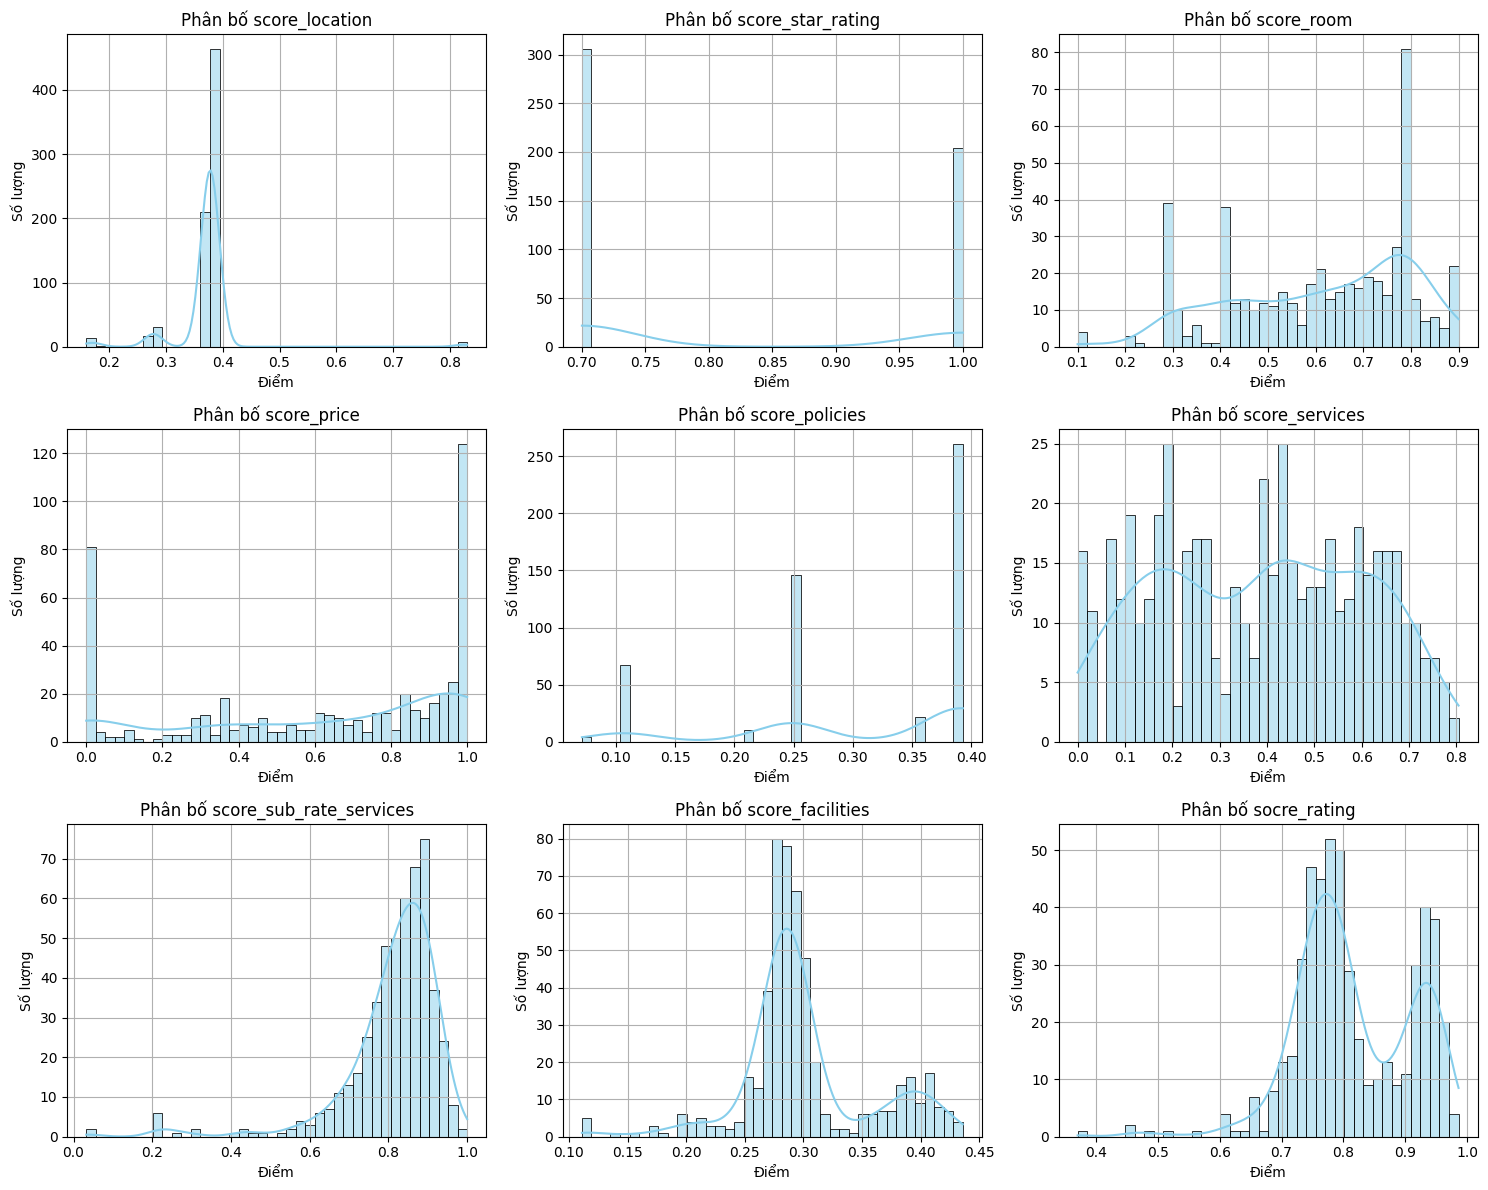

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_many_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_many_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_many_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_many_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_many_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_many_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_many_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_many_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [79]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# T·∫°o DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In k·∫øt qu·∫£
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Tr·ª±c quan h√≥a


Generating weights:   0%|          | 0/117649 [00:00<?, ?it/s]

Generating weights: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 117649/117649 [00:00<00:00, 198216.60it/s]



Testing for k=10


Testing weights (k=10): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:18<00:00, 2747.75it/s]



Testing for k=25


Testing weights (k=25): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:20<00:00, 2539.49it/s]



Testing for k=50


Testing weights (k=50): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:23<00:00, 2214.91it/s]



Results for k=10:
Best weights: {'w_score_location': 0.3, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 60, Diversity: 0.1426, Score: 0.0204

Results for k=25:
Best weights: {'w_score_location': 0.3, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.13333333333333333}
Violations: 150, Diversity: 0.1065, Score: 0.0152

Results for k=50:
Best weights: {'w_score_location': 0.26666666666666666, 'w_score_price': 0.1, 'w_score_policies': 0.1, 'w_score_services': 0.1, 'w_score_facilities': 0.26666666666666666, 'w_socre_rating': 0.16666666666666669}
Violations: 300, Diversity: 0.0989, Score: 0.0141


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: Vi√™Ã£t Nam v√† tr·∫°ng th√°i: C·∫∑p ƒë√¥i
üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]V·ªã tr√≠ & m√¥i tr∆∞·ªùng, D·ªãch v·ª• & nh√¢n vi√™n[/bold #80CFFF]


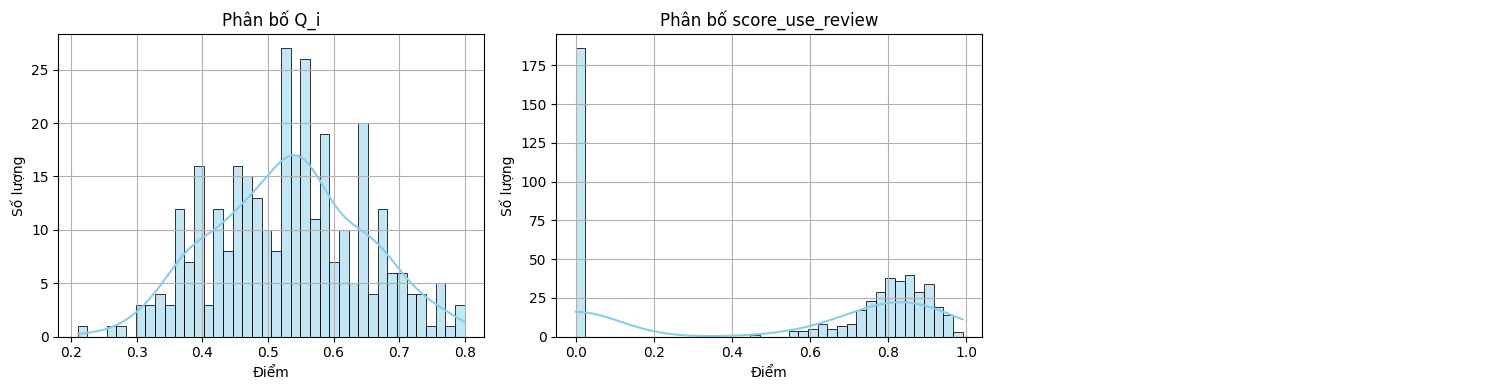

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_many_hotels)

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---

---

In [59]:
query_medium_hotels = {
    'province': 'L√¢m ƒê·ªìng',
    'nearby_places': ['Ch·ª£ ƒê√† L·∫°t', 'H·ªì Xu√¢n H∆∞∆°ng'],
    'is_near_center': True,
    'public_transport_access': ['b·∫øn xe li√™n t·ªânh'],
    'price_range': (300000, 800000),
    'stars_rating': 3,
    'services': ['D·ªãch v·ª• v·∫≠n chuy·ªÉn & b√£i ƒë·ªó xe'],
    'criteria': ['Gi√° tr·ªã', 'S·∫°ch s·∫Ω'],
    'amenities': ['TV', 'm√°y s∆∞·ªüi'],

    'booking_flexibility': ['h·ªßy mi·ªÖn ph√≠', 'thanh to√°n khi nh·∫≠n ph√≤ng'],
    'distance_to_city_center': 3,
    'capacity': 2,
    'country': 'Vi√™Ã£t Nam',
    'state': 'PhoÃÄng gia ƒëiÃÄnh',
    'policies': {
        'Nh·∫≠n ph√≤ng': '13:00-22:00',
        'Tr·∫£ ph√≤ng': '6:00-11:00',
        'V·∫≠t nu√¥i': 'Kh√¥ng cho ph√©p',
        'Ti·ªác t√πng': 'Kh√¥ng t·ªï ch·ª©c ti·ªác',
    },
    'room_type': 'Double Room', 
    'included_breakfast': False,
    'room_level': 'Standard',
    'bed_type': '2 gi∆∞·ªùng ƒë∆°n',
    'area': 25,
    'room_view': ['C·∫£nh th√†nh ph·ªë']
}


üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.
 Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.
 ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
‚úé D·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• v·∫≠n chuy·ªÉn & b√£i ƒë·ªó xe[/bold #80CFFF].
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• v·∫≠n chuy·ªÉn & b√£i ƒë·ªó xe[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]TV, m√°y s∆∞·ªüi[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ ti·ªán nghi b·∫°n qu

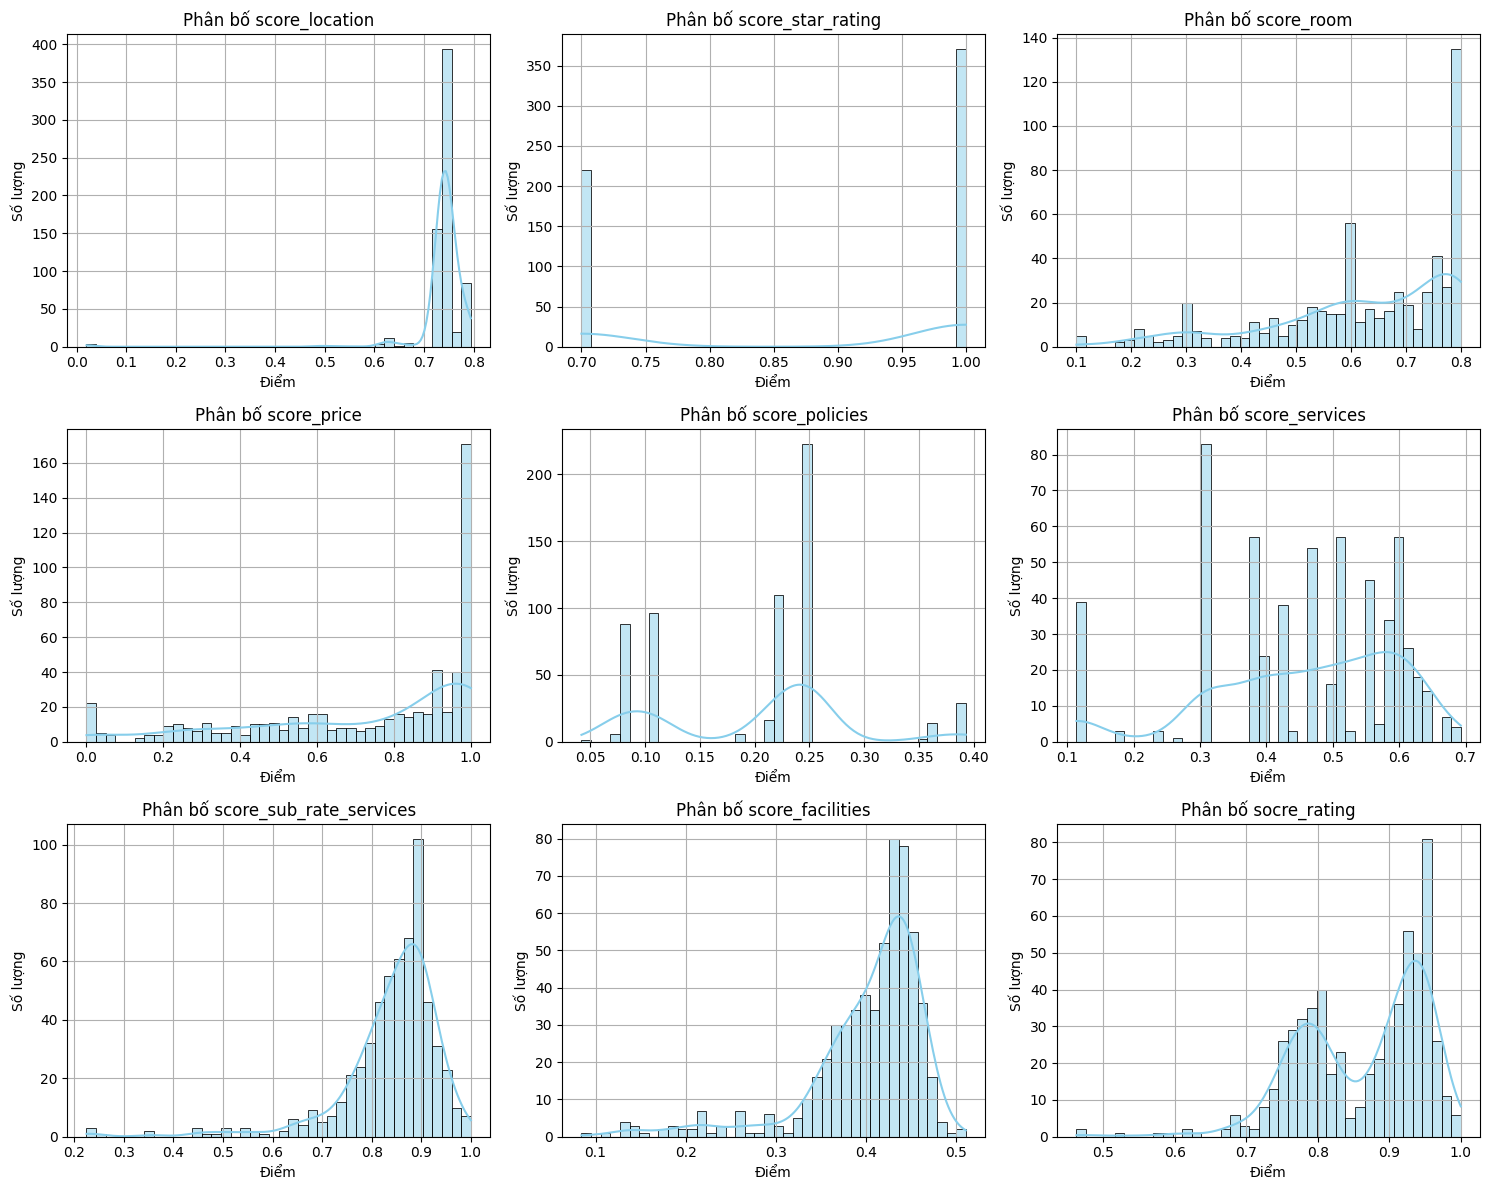

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_medium_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_medium_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_medium_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_medium_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_medium_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_medium_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_medium_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_medium_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [82]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# T·∫°o DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In k·∫øt qu·∫£
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Tr·ª±c quan h√≥a


Generating weights: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 117649/117649 [00:00<00:00, 204999.48it/s]



Testing for k=10


Testing weights (k=10): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:19<00:00, 2555.58it/s]



Testing for k=25


Testing weights (k=25): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:25<00:00, 2025.74it/s]



Testing for k=50


Testing weights (k=50): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:28<00:00, 1760.66it/s]


Results for k=10:
Best weights: {'w_score_location': 0.10344827586206896, 'w_score_price': 0.10344827586206896, 'w_score_policies': 0.27586206896551724, 'w_score_services': 0.20689655172413793, 'w_score_facilities': 0.20689655172413793, 'w_socre_rating': 0.10344827586206896}
Violations: 60, Diversity: 0.0513, Score: 0.0073

Results for k=25:
Best weights: {'w_score_location': 0.10714285714285716, 'w_score_price': 0.10714285714285716, 'w_score_policies': 0.28571428571428575, 'w_score_services': 0.10714285714285716, 'w_score_facilities': 0.28571428571428575, 'w_socre_rating': 0.10714285714285716}
Violations: 150, Diversity: 0.0604, Score: 0.0086

Results for k=50:
Best weights: {'w_score_location': 0.16666666666666669, 'w_score_price': 0.1, 'w_score_policies': 0.3, 'w_score_services': 0.1, 'w_score_facilities': 0.1, 'w_socre_rating': 0.23333333333333334}
Violations: 300, Diversity: 0.0648, Score: 0.0093


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: Vi√™Ã£t Nam v√† tr·∫°ng th√°i: PhoÃÄng gia ƒëiÃÄnh
üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]Gi√° tr·ªã, S·∫°ch s·∫Ω[/bold #80CFFF]


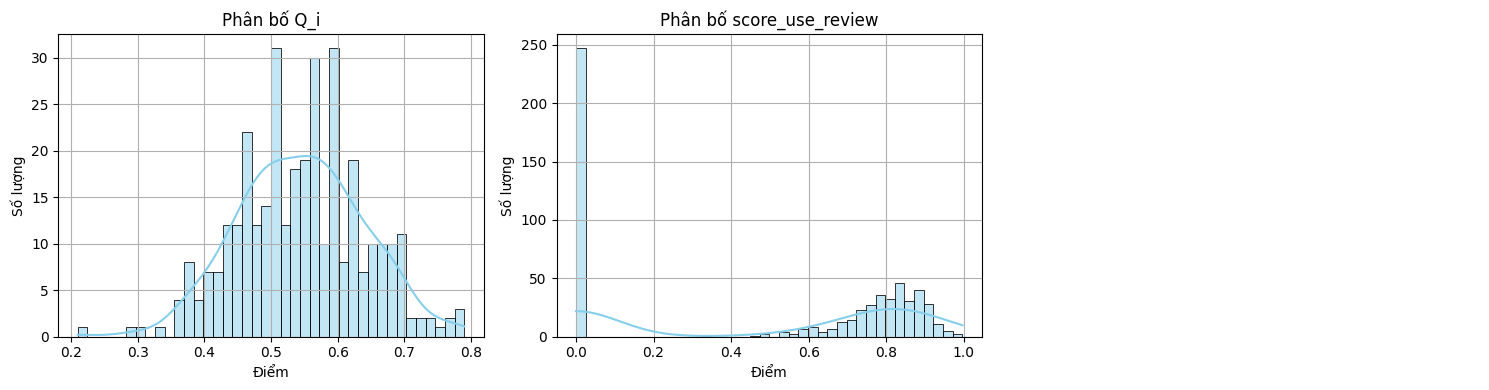

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_medium_hotels)

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:

# B∆∞·ªõc 1: S·∫Øp x·∫øp theo score tƒÉng d·∫ßn
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# B∆∞·ªõc 2: L·∫•y 10 ph·∫ßn t·ª≠ c√°ch ƒë·ªÅu nhau
n = len(sorted_items)
num_samples = 10

# N·∫øu √≠t h∆°n 10 ph·∫ßn t·ª≠, l·∫•y t·∫•t c·∫£
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



---

In [ ]:
.

---

In [65]:
query_few_hotels = {
    'province': 'H√† Giang',
    'nearby_places': ['M√£ P√≠ L√®ng', 'ƒê√®o M√®o V·∫°c'],
    'is_near_center': False,
    'public_transport_access': ['b·∫øn xe huy·ªán'],
    'price_range': (150000, 500000),
    'rating': (2, 4),
    'stars_rating': 2,
    'services': ['D·ªãch v·ª• ·∫©m th·ª±c'],
    'criteria': ['V·ªã tr√≠ & m√¥i tr∆∞·ªùng'],
    'amenities': ['Qu·∫°t m√°y', 'nh√† t·∫Øm ri√™ng'],
    'room_type': ['ph√≤ng ƒë√¥i'],
    'booking_flexibility': ['thanh to√°n khi nh·∫≠n ph√≤ng'],
    'distance_to_city_center': 10,
    'capacity': 2,
    'country': 'Vi√™Ã£t Nam',
    'state': 'Kh√°ch l·∫ª',
    'policies': {
        'Nh·∫≠n ph√≤ng': '12:00-21:00',
        'Tr·∫£ ph√≤ng': '6:00-11:00',
        'V·∫≠t nu√¥i': 'Cho ph√©p',
        'Ti·ªác t√πng': 'Kh√¥ng gi·ªõi h·∫°n',
    },
    'included_breakfast': True,
    'room_level': 'Standard',
    'bed_type': '1 gi∆∞·ªùng ƒë√¥i nh·ªè',
    'area': 15,
    'room_view': ['C·∫£nh n√∫i']
}


üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.
üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán sao.
 Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.
 ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
‚úé D·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• ·∫©m th·ª±c[/bold #80CFFF].
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]D·ªãch v·ª• ·∫©m th·ª±c[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.
üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]Qu·∫°t m√°y, nh√† t·∫Øm ri√™ng[/bold #80CFFF]
 ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ ti·ªán nghi b·∫°n quan t√¢m.
32


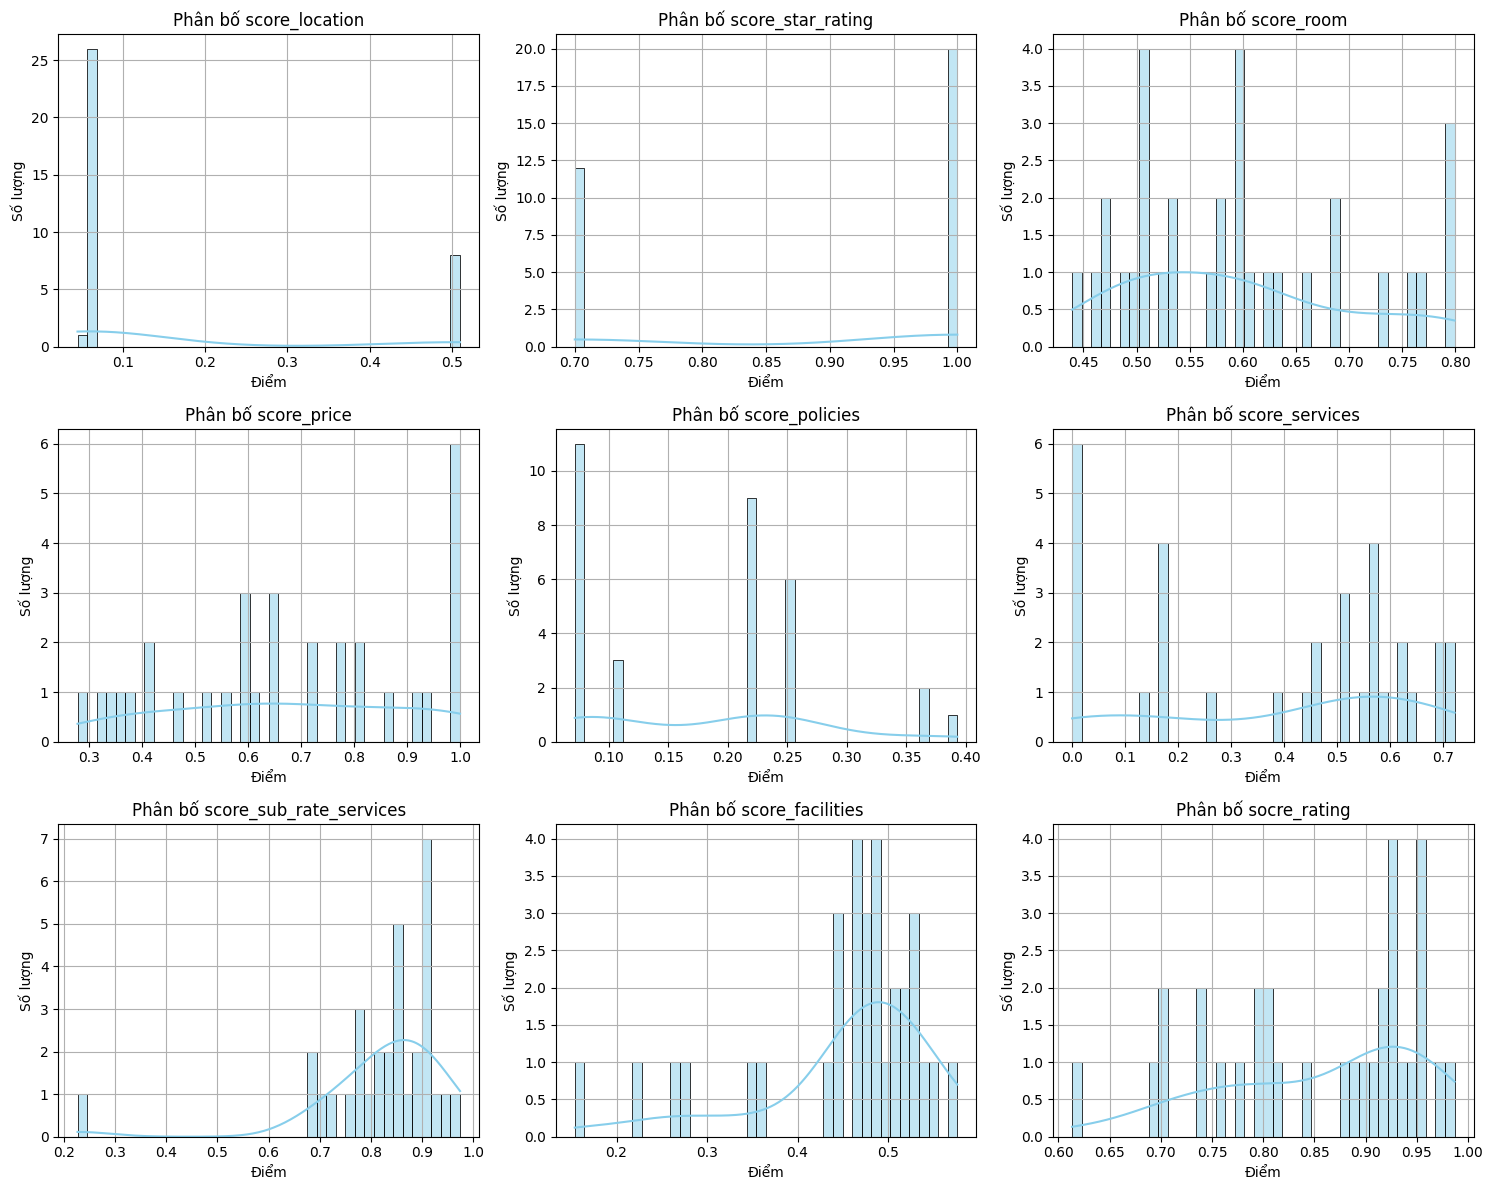

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

ids_result, score_location = get_score_loaction(query_few_hotels)
ids_result, score_star_rating = get_score_star_rating(ids_result, query_few_hotels)
score_price, result_room_price_score = get_score_price(ids_result, query_few_hotels, feature_detail_room)
score_room, result_room_info_score, result_room_info_price_score = get_score_room(ids_result, query_few_hotels, feature_detail_room, result_room_price_score)
score_policies = get_score_policies(ids_result, query_few_hotels, feature_policies)
score_sub_rate_services = get_socre_rate_services(ids_result, query_few_hotels, feature_sub_rate)
score_services = get_score_services(ids_result, query_few_hotels, weights=[0.5, 0.5], beta=1)
score_facilities = get_score_amenities(ids_result, query_few_hotels, similarity_threshold=0.9, normalization_factor_base=10)
socre_rating = dict(utils.compute_total_score(score_star_rating, score_sub_rate_services, weights=[0.5, 0.5]))


print(len(ids_result))

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'score_location': score_location,
    'score_star_rating': score_star_rating,
    'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
scores = {
    'score_location': score_location,
    #'score_star_rating': score_star_rating,
    #'score_room': score_room,
    'score_price': score_price,
    'score_policies': score_policies,
    'score_services': score_services,
    #'score_sub_rate_services': score_sub_rate_services,
    'score_facilities': score_facilities,
    'socre_rating': dict(socre_rating),
}


common_ids = set.intersection(*(set(score.keys()) for score in scores.values()))

# T·∫°o DataFrame
import pandas as pd
data = {name: [scores[name][id] for id in common_ids] for name in scores}
df = pd.DataFrame(data, index=list(common_ids))


k_values = [10, 25, 50]
results_all = test_weights_multi_k(df, k_values=k_values, min_weight=0.1, max_weight=0.3, range_=7)

# In k·∫øt qu·∫£
for result in results_all:
    k = result['k']
    best_weights = result['best_weights']
    print(f"\nResults for k={k}:")
    print("Best weights:", {f'w_{col}': w for col, w in zip(df.columns, best_weights)})
    best_result = max(result['results'], key=lambda x: x['score'])
    print(f"Violations: {best_result['violations']}, Diversity: {best_result['diversity']:.4f}, Score: {best_result['score']:.4f}")

# Tr·ª±c quan h√≥a


Generating weights: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 117649/117649 [00:00<00:00, 234263.16it/s]



Testing for k=10


Testing weights (k=10): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:15<00:00, 3291.10it/s]



Testing for k=25


Testing weights (k=25): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:16<00:00, 3092.08it/s]



Testing for k=50


Testing weights (k=50): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51018/51018 [00:18<00:00, 2821.82it/s]



Results for k=10:
Best weights: {'w_score_location': 0.1, 'w_score_price': 0.26666666666666666, 'w_score_policies': 0.3, 'w_score_services': 0.1, 'w_score_facilities': 0.1, 'w_socre_rating': 0.13333333333333333}
Violations: 25, Diversity: 0.1364, Score: 0.0390

Results for k=25:
Best weights: {'w_score_location': 0.23333333333333334, 'w_score_price': 0.1, 'w_score_policies': 0.13333333333333333, 'w_score_services': 0.16666666666666669, 'w_score_facilities': 0.13333333333333333, 'w_socre_rating': 0.23333333333333334}
Violations: 22, Diversity: 0.1550, Score: 0.0825

Results for k=50:
Best weights: {'w_score_location': 0.15789473684210528, 'w_score_price': 0.15789473684210528, 'w_score_policies': 0.15789473684210528, 'w_score_services': 0.2105263157894737, 'w_score_facilities': 0.15789473684210528, 'w_socre_rating': 0.15789473684210528}
Violations: 0, Diversity: 0.1627, Score: 0.1627


Stats loaded from D:\graduate_dissertation\final\dataset\review_hotel\review_quality.json
üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: Vi√™Ã£t Nam v√† tr·∫°ng th√°i: Kh√°ch l·∫ª
üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]V·ªã tr√≠ & m√¥i tr∆∞·ªùng[/bold #80CFFF]


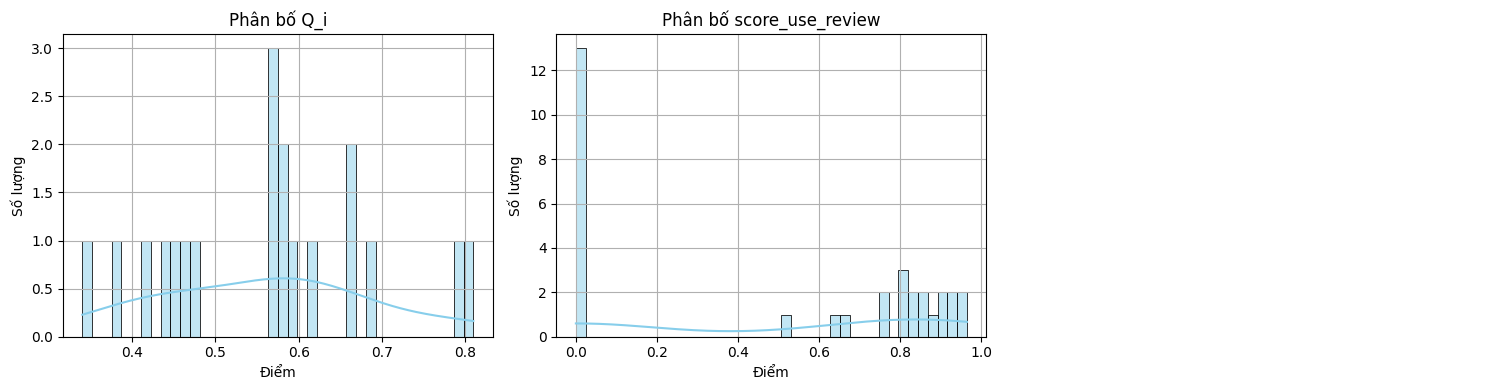

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

import review_quality
hotel_review_stats = review_quality.HotelReviewStats()
states = hotel_review_stats.load_stats()
Q_i = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
score_use_review = get_score_review(ids_result, query_few_hotels)

# Gi·∫£ s·ª≠ scores l√† dict ch·ª©a c√°c score d·∫°ng: {'score_location': [...], 'score_star_rating': [...], ...}
scores = {
    'Q_i': Q_i,
    'score_use_review': score_use_review,
}

# S·ªë l∆∞·ª£ng bi·ªÉu ƒë·ªì c·∫ßn v·∫Ω
n_scores = len(scores)
n_cols = 3  # s·ªë c·ªôt trong b·∫£ng
n_rows = (n_scores + n_cols - 1) // n_cols  # s·ªë h√†ng

# T·∫°o figure v√† axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # chuy·ªÉn 2D array v·ªÅ 1D list ƒë·ªÉ d·ªÖ truy c·∫≠p

# V·∫Ω t·ª´ng bi·ªÉu ƒë·ªì
for idx, (key, values) in enumerate(scores.items()):
    sns.histplot(values, kde=True, bins=40, color='skyblue', ax=axes[idx])
    axes[idx].set_title(f'Ph√¢n b·ªë {key}')
    axes[idx].set_xlabel('ƒêi·ªÉm')
    axes[idx].set_ylabel('S·ªë l∆∞·ª£ng')
    axes[idx].grid(True)

# ·∫®n c√°c √¥ tr·ªëng n·∫øu c√≥
for i in range(len(scores), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

# B∆∞·ªõc 1: S·∫Øp x·∫øp theo score tƒÉng d·∫ßn
sorted_items = sorted(Q_i.items(), key=lambda x: x[1])

# B∆∞·ªõc 2: L·∫•y 10 ph·∫ßn t·ª≠ c√°ch ƒë·ªÅu nhau
n = len(sorted_items)
num_samples = 10

# N·∫øu √≠t h∆°n 10 ph·∫ßn t·ª≠, l·∫•y t·∫•t c·∫£
if n <= num_samples:
    result = [k for k, v in sorted_items]
else:
    step = (n - 1) / (num_samples - 1)
    indices = [round(i * step) for i in range(num_samples)]
    result = [sorted_items[i][0] for i in indices]



In [ ]:
for i in result:
    print(states[i], score_use_review[i])



{'count_review': 12, 'count_review_with_image': 2, 'count_long_review': 2, 'total_score': 97.0, 'num_score': 12, 'avg_score': 8.083333333333334} 0.9653510376423281
{'count_review': 50, 'count_review_with_image': 1, 'count_long_review': 9, 'total_score': 399.0, 'num_score': 50, 'avg_score': 7.98} 0.9322732244135795
{'count_review': 27, 'count_review_with_image': 2, 'count_long_review': 5, 'total_score': 231.0, 'num_score': 27, 'avg_score': 8.555555555555555} 0.7572261871151963
{'count_review': 226, 'count_review_with_image': 13, 'count_long_review': 57, 'total_score': 1737.0, 'num_score': 226, 'avg_score': 7.685840707964601} 0.675457550670848
{'count_review': 167, 'count_review_with_image': 3, 'count_long_review': 42, 'total_score': 1369.0, 'num_score': 167, 'avg_score': 8.197604790419161} 0.8025155941331857
{'count_review': 50, 'count_review_with_image': 9, 'count_long_review': 22, 'total_score': 433.0, 'num_score': 50, 'avg_score': 8.66} 0.8446598435867415
{'count_review': 310, 'count

---

In [ ]:

def get_best_hotels(query, top_n = 30): 

    # ============================================================
    print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm")
    if query.get('nearby_places') or query.get('province'):
        filter_location_hotels = rl.find_hotels_near_location(
            feature_location, query.get('nearby_places', []), query.get('province'), max_distance_km=20
        )
        result_location_hotels_score = rl.get_location_score(
            filter_location_hotels, query.get('nearby_places', []),
            query.get('province'), query.get('is_near_center', False)
        )
    else:
        result_location_hotels_score = feature_location
        for hotel in result_location_hotels_score:
            hotel['location_score'] = 0
    

    score_location = {}
    ids_result = []
    for hotel in result_location_hotels_score:
        ids_result.append(hotel['id'])
        score_location[hotel['id']] = hotel['location_score']

    
    print( f"üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.")


    # ============================================================
    feature_star = []
    for data in feature_star_rating:
        if data['id'] in ids_result:
            feature_star.append(data)

    # 2. Filter star rating
    if query.get('stars_rating') not in [None, '', []]:
        result_stars_hotels_score = fgsp.get_score_rating(query, feature_star)
    else:
        result_stars_hotels_score = []
        for hotel in feature_star_rating:
            result_stars_hotels_score.append({
                'id': hotel['id'],
                'score_rating': 0  
            })
    # OUTPUT: [{'id': '10000593', 'score_rating': 0.5}, {'id': '10000594', 'score_rating': 0.8}, ...]
    # lo·∫°i b·ªè c√°c kh√°ch s·∫°n c√≥ ƒëi·ªÉm ƒë√°nh gi√° < 0.7.

    # ============================================================

    print( f"üîµ Xem nh∆∞ ƒë√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel_room th·ªèa ƒëi·ªÅu ki·ªán lo·∫°i ph√≤ng v√† s·ªë l∆∞·ª£ng.")

    score_stars = {} 
    ids_result = []
    for hotel in result_stars_hotels_score:
        ids_result.append(hotel['id'])
        score_stars[hotel['id']] = hotel['score_rating']

    # mapping
    detail_room = []
    for detail_room_ in feature_detail_room:
        if detail_room_['id'] in ids_result:
            detail_room.append(detail_room_)

    # 3. Filter theo gi√°
    price = query.get('price_range') # x·ª≠ l√Ω input 
    if price not in [None, '', [], (None, None)]:
        result_room_price_score = fgsp.get_price_score(query, detail_room)
        score_price = fgsp.get_max_room_score_per_hotel(result_room_price_score)
    else: 
        score_price = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'hotel_score_price' : 1
            })
        result_room_price_score = []
        for price in detail_room:
            score_price.append({
                'id': price['id'], 
                'room_id': price['room_id'],
                'hotel_score_price' : 1
            })

        # OUTPUT [{'id': '10000593', 'hotel_score_price': 0.9847}, ...]
        # ki·ªÉm tra gi√° th·ª±c t·∫ø so v·ªõi gi√° y√™u c·∫ßu,  nh·ªè h∆°n th√¨ v·∫´n l·∫•y l·ªõn h∆°n th√¨ cƒÉn nhƒÉc 
    
    score_room_info = rr.get_room_info_score(query, detail_room)
    # OUTPUT : {'id': '10000593', 'room_id': 'RD1000059301', 'room_score': 0.6}

    # ============================================================ 
    # T√≠nh ƒëi·ªÉm score_room_info
    score_room = compute_score_room_infor(result_room_price_score, score_room_info) 
    

    # ============================================================
    print( f" Ki·ªÉm tra ch√≠nh s√°ch ph√π h·ª£p.")
    filtered_policies = {} 
    for id in ids_result:
        if id in feature_policies:
            filtered_policies[id] = feature_policies[id]

    score_policies = {} 
    if query.get('policies'):
        for id, data in filtered_policies.items():
            score_policies[id] = rp.find_similar_hotel_policies(query['policies'], data)
            # OUTPUT: {'id':'score', ...}
    
    print( f" ƒê√£ t√¨m ki·∫øm c√°c ch√≠nh s√°ch ph√π h·ª£p v·ªõi y√™u c·∫ßu c·ªßa b·∫°n.")

    # =============================================================
    print( f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.") 
    if query['services']:
        print(f"‚úé D·ªãch v·ª•: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF].")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        result_services = fgr.get_score_sub_rate(services, utils.filter_matching_elements(ids_result, feature_sub_rate))
        score_sub_rate_services = {item['id']: item['score'] for item in result_services}
        # OUTPUT: {'id':'score', ...}

    else:
        print(f"‚úé D·ªãch v·ª•: R·ªóng")
        print(f"‚úé D·ª±a v√†o c√°c ti·ªán √≠ch m√† b·∫°n y√™u c·∫ßu: [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF].")
        designated_utility = set()
        for amenity in query['amenities']:
            cluster = fga.find_clusters([amenity], threshold=0.01)
            designated_utility.update(cluster)
        designated_utility = list(designated_utility)
        print(f"‚úé N√™n s·∫Ω ∆∞u ti√™n c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh cao v·ªõi c√°c ti√™u ch√≠ ƒë√£ ph·ª•c thu·ªôc c√°c ti·ªán √≠ch tr√™n.")
        score_sub_rate_services = fgr.get_score_sub_rate(designated_utility, 
                                                  utils.filter_matching_elements(ids_result, feature_sub_rate))
        # OUTPUT: {'id':'score', ...}
    
    print(" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n ƒë∆∞·ª£c ƒë√°nh gi√° cao v·ªÅ d·ªãch v·ª• c·ªßa b·∫°n.")


    # ============================================================
    if query['services']:
        print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ d·ªãch v·ª•: [bold #80CFFF]{', '.join(query['services'])}[/bold #80CFFF]")
        services = set()
        for criteria in query['services']:
            services.update(utils.convert_group(criteria, "services", "expand"))
        score_services = fga.get_score_services(user_input = list(services), 
                                    List_ids = ids_result, 
                                    weights=[0.5, 0.5])
        score_services = {item['id']: item['final_score'] for item in score_services}
        # OUTPUT: {'id':'score', ...} score n√†y ch∆∞a chu·∫©n h√≥a 
        
        print(f" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n kh·ªõp d·ªãch v·ª• b·∫°n quan t√¢m.")

    # ============================================================
    if query['amenities']:
        print(f"üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n ch·ª©a c√°c ti·ªán nghi [bold #80CFFF]{', '.join(query['amenities'])}[/bold #80CFFF]")
        result_facilities_hotel = recommend_faclities_hotel.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=0.9, 
            normalization_factor_base=10
        )
        result_facilities_room = recommend_faclities_room.predict_assignID(
            input_amenities= query['amenities'],
            hotel_ids=ids_result,
            similarity_threshold=0.9, 
            normalization_factor_base=10
        )

        score_facilities = fga.calculate_hotel_scores(result_facilities_hotel, 
                                   result_facilities_room, 
                                   threshold=0.9, 
                                   weight=[0.5, 0.5])
        
        print(f" ƒê√£ t√¨m ki·∫øm c√°c kh√°ch s·∫°n c√≥ ti·ªán nghi b·∫°n quan t√¢m.")

    print(f"Danh s√°ch kh√°ch s·∫°n ƒë√£ t√¨m ki·∫øm ƒë∆∞·ª£c:")
    result_final_info_score = utils.compute_intersection_score(score_facilities, 
                                                            score_sub_rate_services, 
                                                            score_services,
                                                            score_policies,
                                                            score_location, 
                                                            score_stars,
                                                            weights=(0.2, 0.2, 0.3, 0.1, 0.1, 0.1))
    result_final_info_score = dict(result_final_info_score)
    # OUTPUT : {'id':'score', ...}


    # ============================================================
    print("============================================================")
    print("Giai ƒëo·∫°n 2:")
    print("Ki·ªÉm tra ph·∫£n h√≤i c·ªßa kh√°ch h√†ng")
    score_review_quality = hotel_review_stats.calculate_final_score_local_data(ids_result, print_warning=False)
    if not query['country'] and not query['state']: # TH kh√¥ng c√≥ th√¥ng tin v·ªÅ qu·ªëc gia v√† tr·∫°ng th√°i
        if not query['criteria']: # TH kh√¥ng c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                #user_weights = rhr.allocate_weights_with_ratios(), 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))

            # T√≠nh ƒëi·ªÉm cu·ªëi c√πng
            result_final_review_score = rhr.calculate_final_score_from_reviews(
                score_review, 
                score_review_quality, 
                w=0.8, 
                q_default=0.5, 
                s_global=0.7, 
                threshold=0.3
            )
            result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
            # OUTPUT : {'id':'score', ...}
        else: # TH c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            print(f"üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
            score_review = rhr.calculate_weighted_bayesian_score(
                result_groupby_id = {id: result_groupby_id[id] for id in ids_result if id in result_groupby_id},
                user_weights = weights, 
                C=100
                )
            score_review = dict(zip(score_review['hotel_id'], score_review['bayesian_score']))
            result_final_review_score = rhr.calculate_final_score_from_reviews(
                score_review, 
                score_review_quality, 
                w=0.8, 
                q_default=0.5, 
                s_global=0.7, 
                threshold=0.2
            )
            result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
            # OUTPUT : {'id':'score', ...}

    else: # TH c√≥ th√¥ng tin v·ªÅ qu·ªëc gia v√† tr·∫°ng th√°i
        print(f"üîµ C·∫£m ∆°n b·∫°n ƒë√£ cung c·∫•p th√¥ng tin v·ªÅ qu·ªëc gia: {query['country']} v√† tr·∫°ng th√°i: {query['state']}")
        result = CF.aggregate_prediction(hotel_ids = ids_result, 
                                            country = query['country'], 
                                            status = query['state'], 
                                            state_model=state_model, 
                                            country_model=country_model, 
                                            print_result=False, 
                                            print_warning=False,
                                            )
        if query['criteria']: # TH c√≥ th√¥ng tin v·ªÅ ti√™u ch√≠
            print(f"üîµ T·∫≠p trung m·∫°nh v√†o kh√°ch s·∫°n c√≥ ti√™u ch√≠: [bold #80CFFF]{', '.join(query['criteria'])}[/bold #80CFFF]")
            criterion = set()
            for criteria in query['criteria']:
                criterion.update(utils.convert_group(criteria, "criteria", "expand"))
            criterion = {key: 1 for key in criterion}
            weights = rhr.allocate_weights_with_ratios(criterion)
        else:
            weights = rhr.allocate_weights_with_ratios()

        score_review = {}
        for key, value in result.items():
            score_review[key] = sum(value[key1] * weights[key1] for key1 in value) / sum(weights.values())
        
        result_final_review_score = rhr.calculate_final_score_from_reviews(
            score_review, 
            score_review_quality, 
            w=0.8, 
            q_default=0.5, 
            s_global=0.7, 
            threshold=0.2
        )
        result_final_review_score = dict(zip(result_final_review_score['id'], result_final_review_score['final_score']))
        # OUTPUT : {'id':'score', ...}

    
    # K·∫øt h·ª£p c√°c ƒëi·ªÉm s·ªë
    result_hotel_score = utils.compute_intersection_score(
        result_final_info_score,
        result_final_review_score, 
        weights=(0.7, 0.3)
    )

    detail_score_dicts = [
    score_facilities,
    score_sub_rate_services,
    score_services,
    score_policies,
    score_location,
    score_stars,
    result_final_review_score
    ]
    score_keys = ['score_facilities', 'score_sub_rate_services', 'score_services', 'score_policies', 'score_location', 'score_stars', 'result_final_review_score']

    result_final_score = combine_room_and_hotel_scores_with_details( score_room,result_hotel_score, detail_score_dicts,  score_keys, weight=0.6)

        

    return result_final_score[:top_n]

In [ ]:
result = get_best_hotels(query, top_n = 10)

üîµ B·∫Øt ƒë·∫ßu t√¨m ki·∫øm kh√°ch s·∫°n theo ƒë·ªãa ƒëi·ªÉm

üîµ ƒê√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel th·ªèa ƒëi·ªÅu ki·ªán ƒë·ªãa l√Ω.

üîµ Xem nh∆∞ ƒë√£ thu ƒë∆∞·ª£c danh s√°ch c√°c ID hotel_room th·ªèa ƒëi·ªÅu ki·ªán lo·∫°i ph√≤ng v√† s·ªë l∆∞·ª£ng.

TypeError: unhashable type: 'dict'

In [ ]:
import matplotlib.pyplot as plt

def plot_final_score_breakdown(scores, hotel_id=None, room_id=None):
    """
    V·∫Ω bi·ªÉu ƒë·ªì ph√¢n t√≠ch ƒëi·ªÉm final_score theo c√°c th√†nh ph·∫ßn:
        - Hotel Info (Facilities, Services, etc.)
        - Final Review Score
        - Room Info

    Args:
        scores (dict): Dictionary ch·ª©a c√°c ƒëi·ªÉm sau v·ªõi keys:
            - 'score_facilities', 'score_sub_rate_services', 'score_services',
              'score_policies', 'score_location', 'score_stars',
              'result_final_review_score', 'score_room_infor'
        hotel_id (str/int): Optional hotel identifier
        room_id (str/int): Optional room identifier
    """

    # Tr·ªçng s·ªë c·ªßa t·ª´ng ph·∫ßn
    component_weights = {
        'score_facilities': 0.2,
        'score_sub_rate_services': 0.2,
        'score_services': 0.3,
        'score_policies': 0.1,
        'score_location': 0.1,
        'score_stars': 0.1,
        'result_final_review_score': 0.3,     # ph·∫ßn trong hotel 60%
        'score_room': 0.4               # ph·∫ßn ri√™ng
    }

    # T√≠nh ƒëi·ªÉm th√†nh ph·∫ßn
    core_score = sum(scores[k] * component_weights[k] for k in [
        'score_facilities', 'score_sub_rate_services', 'score_services',
        'score_policies', 'score_location', 'score_stars'
    ])
    hotel_partial = 0.7 * core_score + 0.3 * scores['result_final_review_score']
    hotel_contribution = 0.6 * hotel_partial
    room_contribution = 0.4 * scores['score_room']
    final_score = hotel_contribution + room_contribution

    # Chu·∫©n b·ªã d·ªØ li·ªáu ƒë·ªÉ v·∫Ω
    bar_parts = {
        'Hotel Info (Facilities + Services + Location + etc.)': 0.6 * 0.7 * core_score,
        'Hotel Info (Final Review)': 0.6 * 0.3 * scores['result_final_review_score'],
        'Room Info': 0.4 * scores['score_room']
    }

    # V·∫Ω bi·ªÉu ƒë·ªì
    fig, ax = plt.subplots(figsize=(10, 2))
    left = 0
    colors = ['#66c2a5', '#fc8d62', '#8da0cb']

    for i, (label, value) in enumerate(bar_parts.items()):
        ax.barh(0, value, left=left, label=f'{label}: {value:.2f}', color=colors[i])
        left += value

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    title = f"Final Score Breakdown = {final_score:.3f}"
    if hotel_id is not None:
        title += f" | Hotel ID: {hotel_id}"
    if room_id is not None:
        title += f" | Room ID: {room_id}"
    ax.set_title(title)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout()
    plt.show()




In [ ]:
import matplotlib.pyplot as plt

def plot_final_score_breakdown(scores, hotel_id=None, room_id=None):
    """
    V·∫Ω bi·ªÉu ƒë·ªì ph√¢n t√≠ch chi ti·∫øt final_score v·ªõi ƒë·∫ßy ƒë·ªß c√°c y·∫øu t·ªë.
    """
    # Tr·ªçng s·ªë ban ƒë·∫ßu c·ªßa t·ª´ng y·∫øu t·ªë trong hotel_info
    hotel_weights = {
        'score_facilities': 0.2,
        'score_sub_rate_services': 0.2,
        'score_services': 0.3,
        'score_policies': 0.1,
        'score_location': 0.1,
        'score_stars': 0.1,
    }

    # Tr·ªçng s·ªë theo c√¥ng th·ª©c final_score
    contributions = {}
    for k, w in hotel_weights.items():
        # 60% hotel * 70% hotel_info * w
        contributions[k] = 0.6 * 0.7 * w * scores[k]

    # Final review
    contributions['result_final_review_score'] = 0.6 * 0.3 * scores['result_final_review_score']

    # Room info
    contributions['score_room'] = 0.4 * scores['score_room']

    # T·ªïng ƒëi·ªÉm cu·ªëi c√πng
    final_score = sum(contributions.values())

    # T·∫°o danh s√°ch labels v√† gi√° tr·ªã ƒë·ªÉ v·∫Ω
    labels = {
        'score_facilities': 'Facilities',
        'score_sub_rate_services': 'Sub-Rate Services',
        'score_services': 'Services',
        'score_policies': 'Policies',
        'score_location': 'Location',
        'score_stars': 'Stars',
        'result_final_review_score': 'Final Review Score',
        'score_room': 'Room Info'
    }

    colors = ['#66c2a5', '#a6d854', '#ffd92f', '#e78ac3',
              '#8da0cb', '#fc8d62', '#e5c494', '#b3b3b3']

    fig, ax = plt.subplots(figsize=(12, 2.5))
    left = 0

    for i, (key, value) in enumerate(contributions.items()):
        label = labels.get(key, key)
        ax.barh(0, value, left=left, label=f'{label}: {value:.3f}', color=colors[i])
        left += value

    ax.set_xlim(0, 1)
    ax.set_yticks([])
    title = f"Final Score Breakdown = {final_score:.3f}"
    if hotel_id is not None:
        title += f" | Hotel ID: {hotel_id}"
    if room_id is not None:
        title += f" | Room ID: {room_id}"
    ax.set_title(title)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    plt.tight_layout()
    plt.show()


In [ ]:
def analyze_results(result, feature_url):
    # T·∫°o dict ƒë·ªÉ tra nhanh t·ª´ list feature_url
    url_dict = {item["id"]: item["url"] for item in feature_url}

    for item in result:
        hotel_id = item['id']
        room_id = item['room_id']

        # In ra URL n·∫øu c√≥
        if hotel_id in url_dict:
            print(f"Hotel ID: {hotel_id} | URL: {url_dict[hotel_id]}")
        else:
            print(f"Hotel ID: {hotel_id} | URL not found")

        plot_final_score_breakdown(item, hotel_id, room_id)


Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

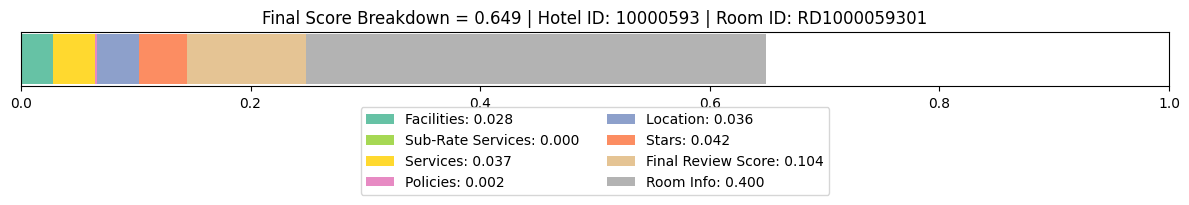

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

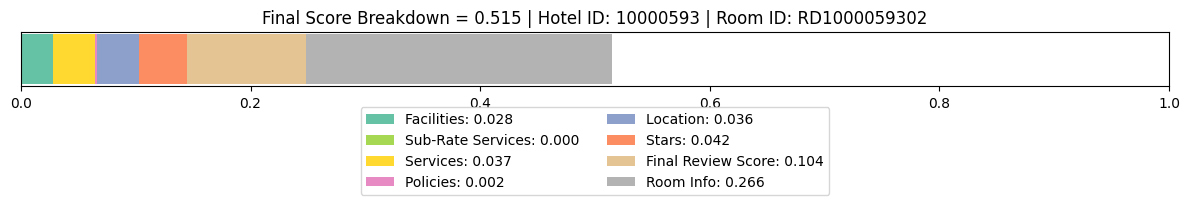

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

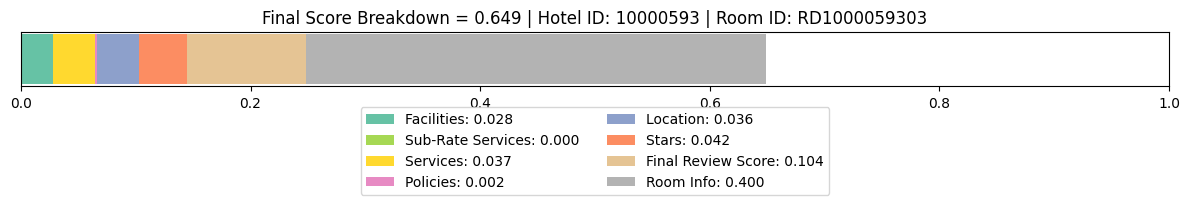

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

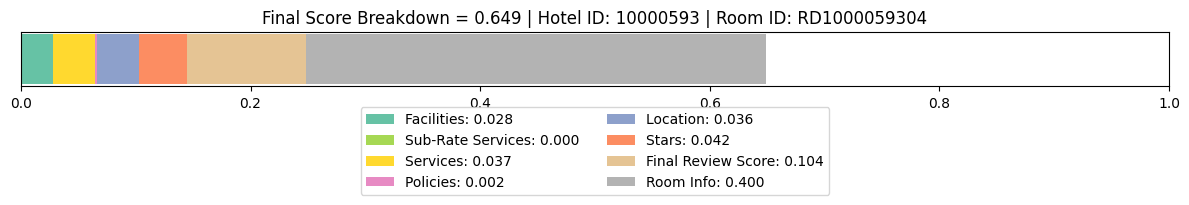

Hotel ID: 10000593 | URL: 
https://www.booking.com/hotel/vn/fairy-mountain-retreat.vi.html?checkin=2025-05-25&checkout=2025-05-26

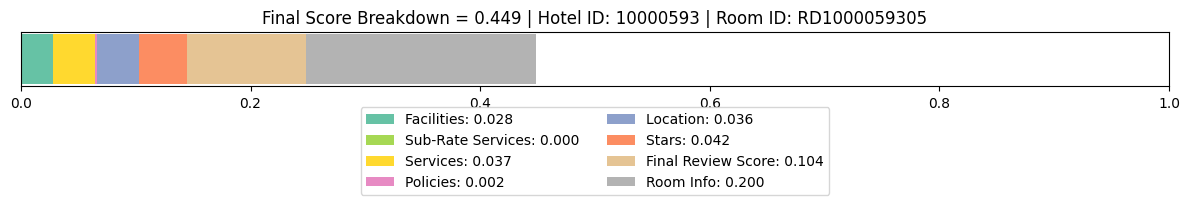

Hotel ID: 10074479 | URL: 
https://www.booking.com/hotel/vn/nham-village-resort.vi.html?checkin=2025-05-25&checkout=2025-05-26

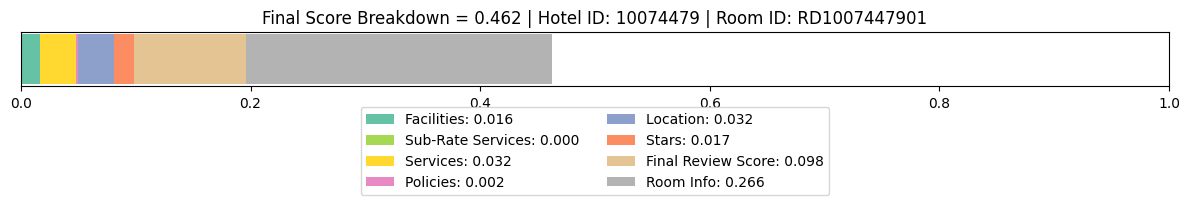

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

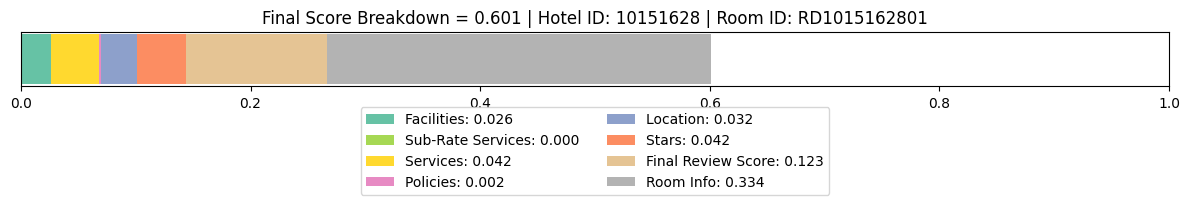

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

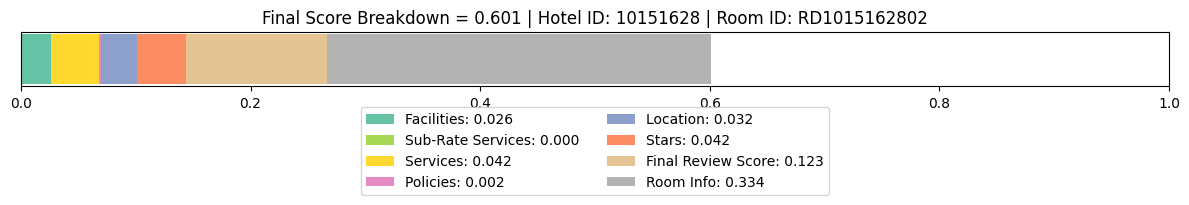

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

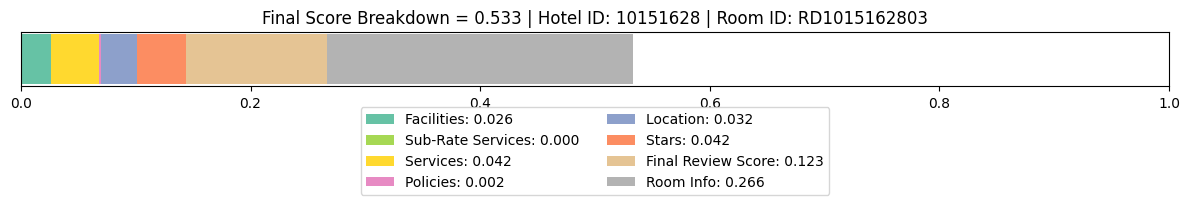

Hotel ID: 10151628 | URL: 
https://www.booking.com/hotel/vn/tam-coc-windy-fields.vi.html?checkin=2025-05-25&checkout=2025-05-26

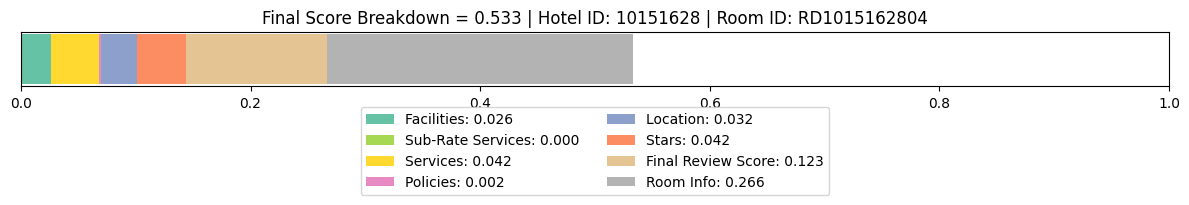

In [ ]:
analyze_results(a, feature_url)